In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0        0.932573  0.113691 -0.402206  0.378386 -0.203938 -0.413469  0.965623   
1        0.810802 -0.514115  0.742368 -0.616673 -0.194255  1.771210  1.428127   
2        0.393974  0.615937  0.567806 -0.607963  0.068883 -1.083155  0.979656   
3       -2.343535 -0.011870  1.874606 -0.606346 -0.586827 -0.815737  0.778096   
4        0.842057 -0.262993  2.330030 -0.583422 -0.618392 -0.742814 -0.946789   
...           ...       ...       ...       ...       ...       ...       ...   
3141405  0.093530 -0.720275 -0.345497 -0.438781 -0.166972 -0.437182  1.475746   
3141406 -1.344935 -0.199987 -0.107702 -0.454677 -0.221914 -0.141174 -1.498235   
3141407  0.979489 -1.110491  1.006980 -0.467307 -0.159549  1.355671  0.150812   
3141408 -2.565332  0.320301  0.076600  1.380182 -0.155366 -0.689000  0.381069   
3141409 -0.089557  0.190229 -0.548256  0.151205  0.079773  0.447962  1.014983   

              f_7       f_8       f_9  ...     f_290     f_291     f_292  \
0        1.230508  0.114809 -2.012777  ...  0.366028 -1.095620  0.200075   
1        1.134144  0.114809 -0.219201  ... -0.154193  0.912726 -0.734579   
2       -1.125681  0.114809 -1.035376  ... -0.138020  0.912726 -0.551904   
3        0.298990  0.114809 -1.176410  ...  0.382201  0.912726 -0.266359   
4        1.230508  0.114809 -0.005858  ... -0.170365  0.912726 -0.741355   
...           ...       ...       ...  ...       ...       ...       ...   
3141405  1.284423  0.056425 -1.433681  ... -0.285908 -1.232434 -0.660579   
3141406  1.373834  0.056425 -1.211572  ...  0.184517 -1.232434 -0.670493   
3141407 -0.088923  0.056425  0.996380  ... -0.756332 -1.232434  0.820784   
3141408 -1.324759  0.056425 -1.111730  ... -0.756332 -1.232434  0.133074   
3141409 -1.324759  0.056425 -1.952123  ... -0.317095  0.811402  3.271590   

            f_293     f_294     f_295     f_296     f_297     f_298     f_299  
0        0.819155  0.941183 -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
1        0.819155  0.941183 -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
2       -1.220772 -1.060166 -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
3       -1.220772  0.941183 -0.609113  0.104928 -0.783423  1.151730 -0.773309  
4       -1.220772  0.941183 -0.588445  0.104928  0.753279  1.345611 -0.737624  
...           ...       ...       ...       ...       ...       ...       ...  
3141405  0.875537  0.421628 -0.428097 -0.075548 -0.533092 -0.193732 -0.581394  
3141406  0.875537  0.421628 -0.729949 -1.514277  0.013145 -0.890270 -0.589705  
3141407 -1.142157  0.421628 -0.363329  1.363181 -0.079106 -1.580124 -0.297625  
3141408 -1.142157  0.421628 -0.375288 -1.514277 -0.973762  0.608647 -0.372040  
3141409  0.875537  0.421628 -0.170709  1.363181 -0.563314  0.669586  0.456400  

[3141410 rows x 300 columns]

target
0       -0.300875
1       -0.231040
2        0.568807
3       -1.064780
4       -0.531940
...           ...
3141405  0.033600
3141406 -0.223264
3141407 -0.559415
3141408  0.009599
3141409  1.212112

[3141410 rows x 1 columns]

time_id
0              0
1              0
2              0
3              0
4              0
...          ...
3141405     1219
3141406     1219
3141407     1219
3141408     1219
3141409     1219

[3141410 rows x 1 columns]

In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

156

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'drop_rate': 0.2,
    'feature_fraction': 0.15000000000000002,
    'lambda_l1': 0.43676762370794986,
    'lambda_l2': 0.03245387863155825,
    'max_drop': 10,
    'min_data_in_leaf': 800,
    'num_iterations': 1400,
    'path_smooth': 0.47386345609006675,
    'skip_drop': 0.5,
    'num_leaves': 128
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338
[50]	valid_0's rmse: 0.899227	valid_0's pearsonr: 0.127977
[100]	valid_0's rmse: 0.898063	valid_0's pearsonr: 0.132045
[150]	valid_0's rmse: 0.896912	valid_0's pearsonr: 0.136147
[200]	valid_0's rmse: 0.896174	valid_0's pearsonr: 0.136515
[250]	valid_0's rmse: 0.895997	valid_0's pearsonr: 0.136054
[300]	valid_0's rmse: 0.89551	valid_0's pearsonr: 0.136554
[350]	valid_0's rmse: 0.895193	valid_0's pearsonr: 0.137386
[400]	valid_0's rmse: 0.895043	valid_0's pearsonr: 0.138365
[450]	valid_0's rmse: 0.895036	valid_0's pearsonr: 0.138036
[500]	valid_0's rmse: 0.894753	valid_0's pearsonr: 0.138901
[550]	valid_0's rmse: 0.894548	valid_0's pearsonr: 0.139955
[600]	valid_0's rmse: 0.894519	valid_0's pearsonr: 0.140104
[650]	valid_0's rmse: 0.89442	valid_0's pearsonr: 0.140561
[700]	valid_0's rmse: 0.89429	valid_0'

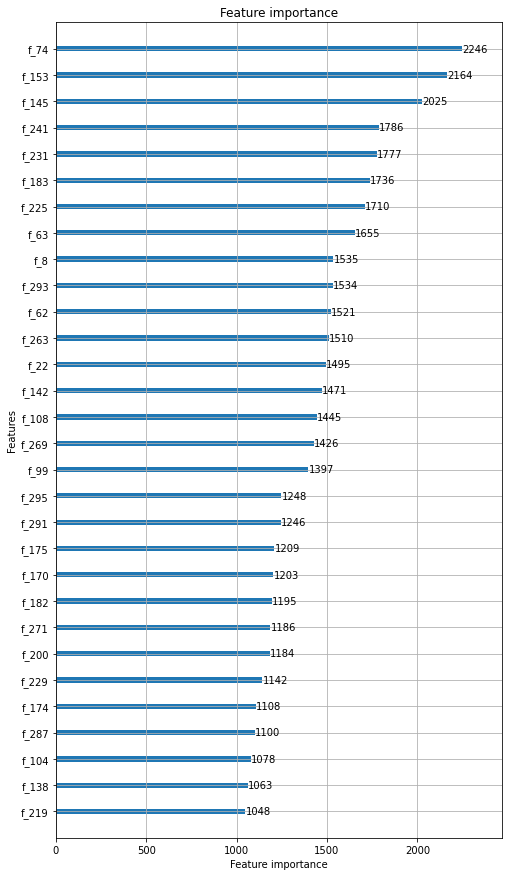

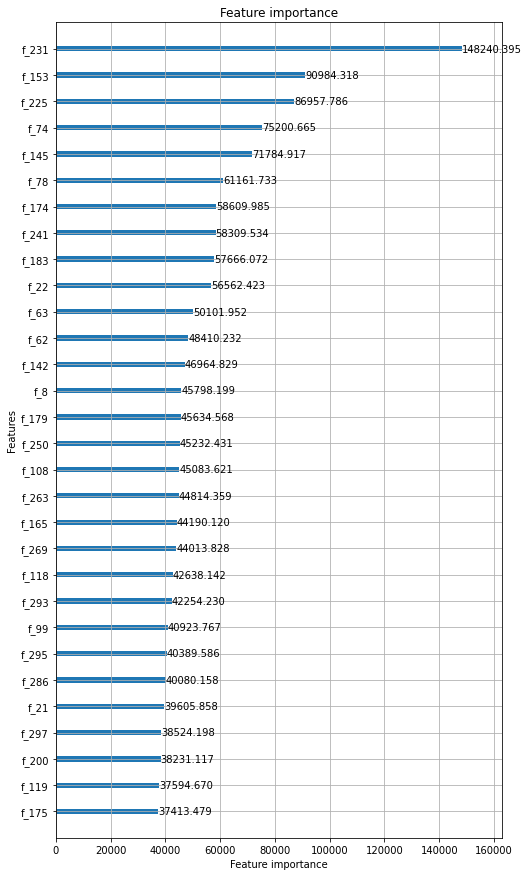

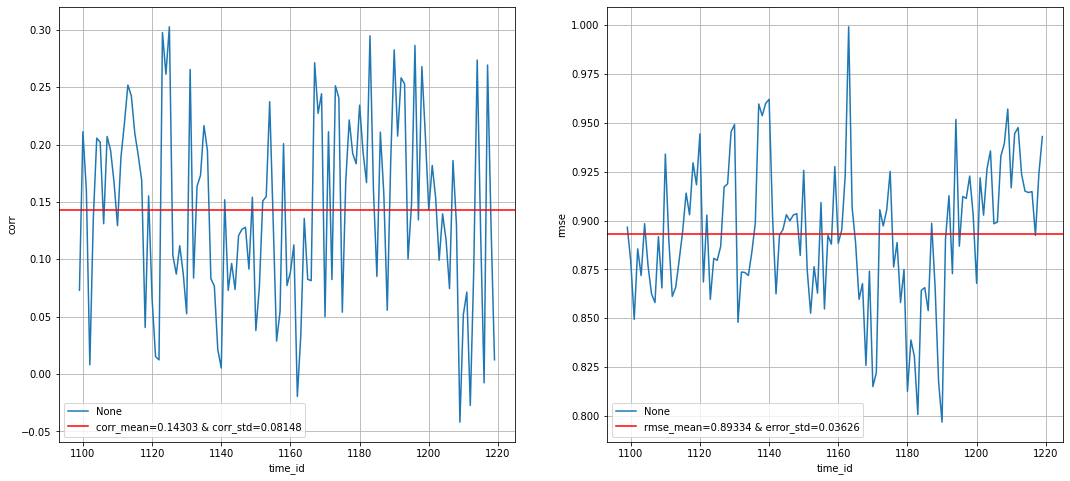

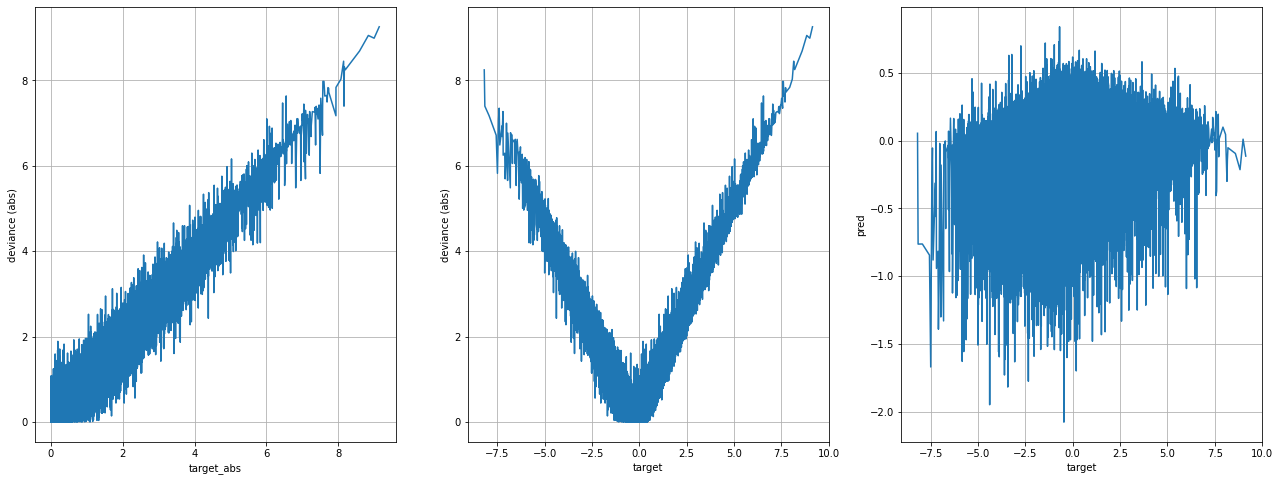

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609
[50]	valid_0's rmse: 0.90673	valid_0's pearsonr: 0.114954
[100]	valid_0's rmse: 0.905613	valid_0's pearsonr: 0.120856
[150]	valid_0's rmse: 0.904624	valid_0's pearsonr: 0.125757
[200]	valid_0's rmse: 0.903725	valid_0's pearsonr: 0.130027
[250]	valid_0's rmse: 0.903315	valid_0's pearsonr: 0.132989
[300]	valid_0's rmse: 0.902791	valid_0's pearsonr: 0.134195
[350]	valid_0's rmse: 0.902405	valid_0's pearsonr: 0.135368
[400]	valid_0's rmse: 0.902217	valid_0's pearsonr: 0.136628
[450]	valid_0's rmse: 0.902105	valid_0's pearsonr: 0.137333
[500]	valid_0's rmse: 0.901776	valid_0's pearsonr: 0.138467
[550]	valid_0's rmse: 0.901582	valid_0's pearsonr: 0.139242
[600]	valid_0's rmse: 0.901525	valid_0's pearsonr: 0.139606
[650]	valid_0's rmse: 0.90144	valid_0's pearsonr: 0.139831
[700]	valid_0's rmse: 0.90131	valid_0'

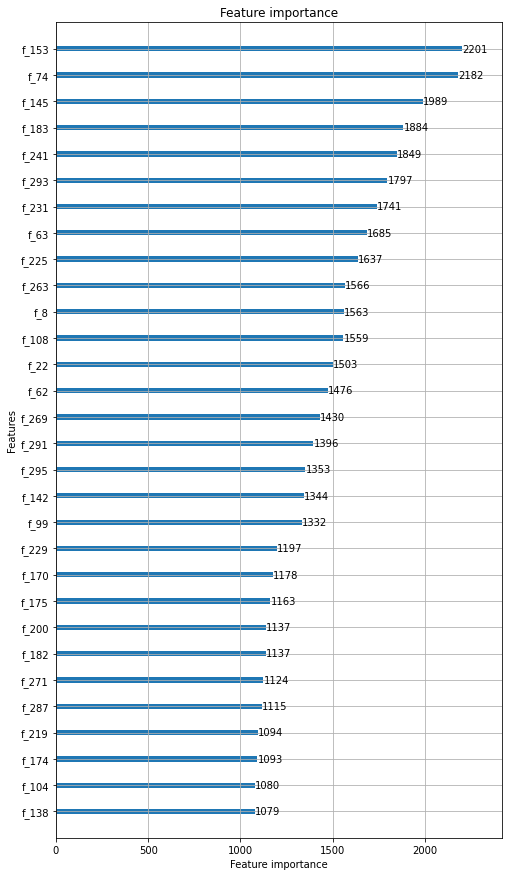

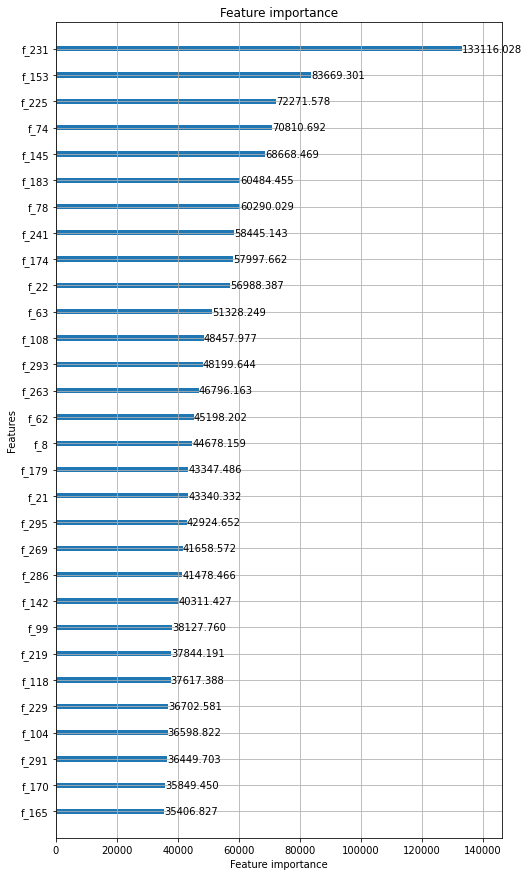

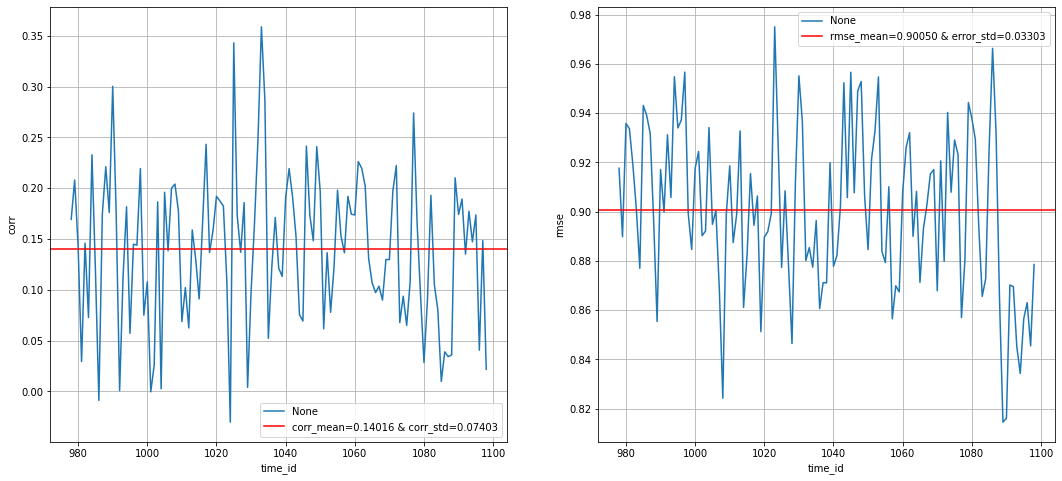

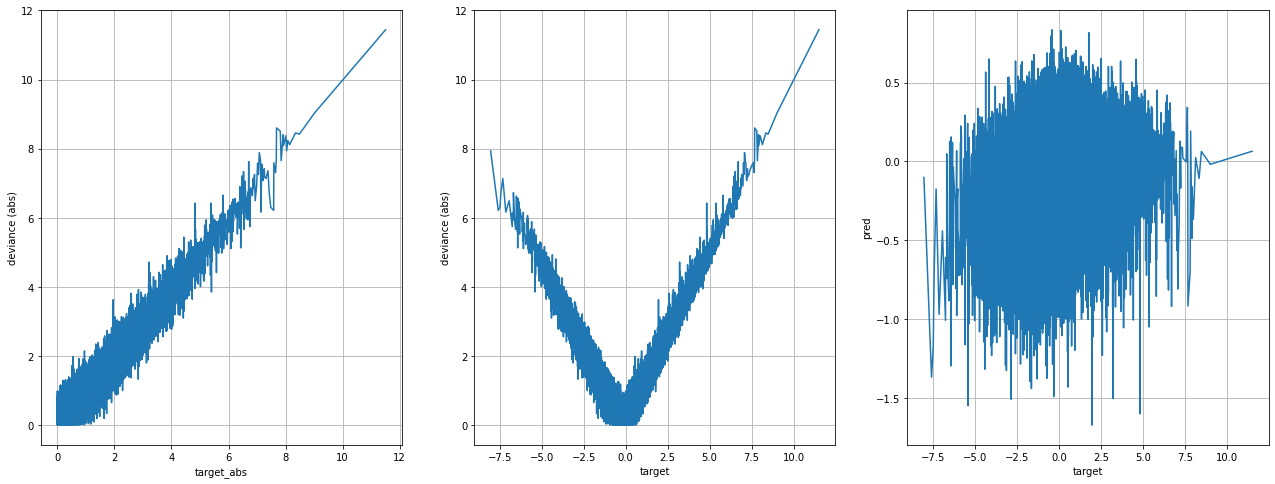

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871
[50]	valid_0's rmse: 0.940909	valid_0's pearsonr: 0.0947738
[100]	valid_0's rmse: 0.940023	valid_0's pearsonr: 0.100592
[150]	valid_0's rmse: 0.939166	valid_0's pearsonr: 0.107185
[200]	valid_0's rmse: 0.938574	valid_0's pearsonr: 0.110194
[250]	valid_0's rmse: 0.938016	valid_0's pearsonr: 0.115803
[300]	valid_0's rmse: 0.937474	valid_0's pearsonr: 0.119055
[350]	valid_0's rmse: 0.936979	valid_0's pearsonr: 0.122622
[400]	valid_0's rmse: 0.936766	valid_0's pearsonr: 0.124263
[450]	valid_0's rmse: 0.936529	valid_0's pearsonr: 0.126295
[500]	valid_0's rmse: 0.936175	valid_0's pearsonr: 0.128454
[550]	valid_0's rmse: 0.935781	valid_0's pearsonr: 0.131411
[600]	valid_0's rmse: 0.935643	valid_0's pearsonr: 0.132515
[650]	valid_0's rmse: 0.935465	valid_0's pearsonr: 0.133667
[700]	valid_0's rmse: 0.93521	valid

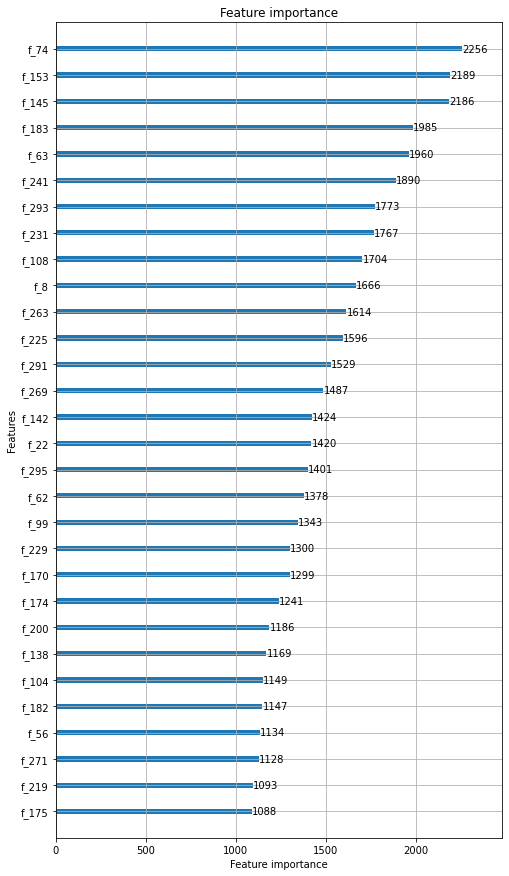

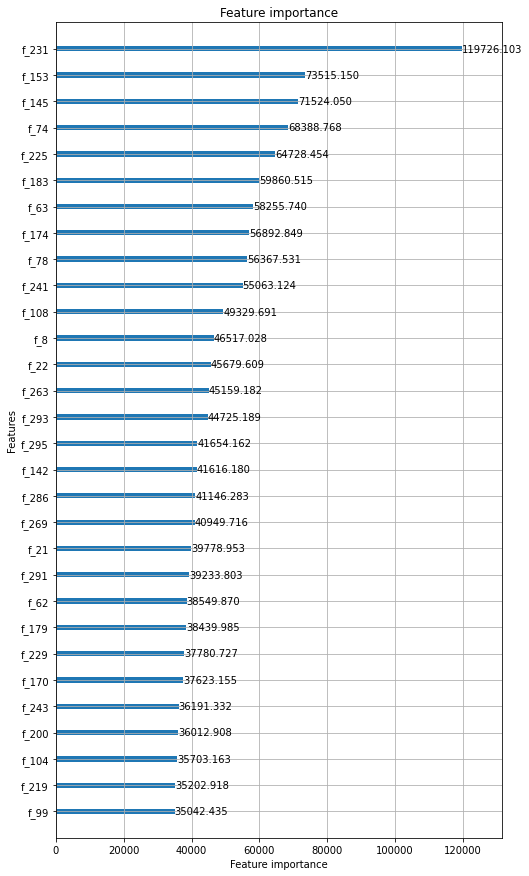

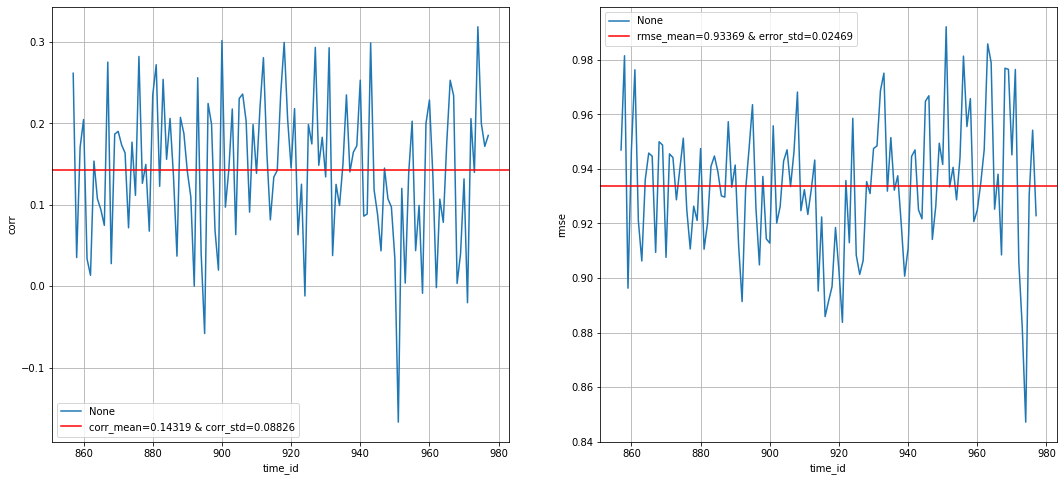

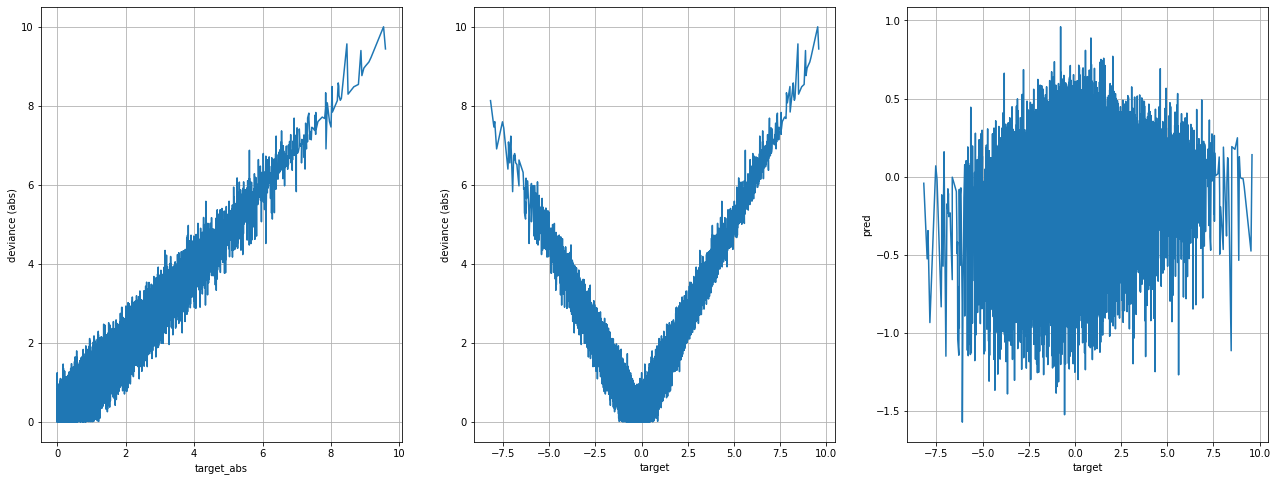

n_iterations: 0


In [10]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        log_callback = lgb.log_evaluation(period=50,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 546
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.14303488598830308, 0.14016137212867122, 0.14319456454785726],
 'corr_std': [0.08147895042263513, 0.07402680645690733, 0.08825690419093488],
 'error_mean': [0.8933403729270174, 0.9004965164047004, 0.9336943738530491],
 'error_std': [0.03625500953502804, 0.033028743497627515, 0.02469012105978876]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.1421302742216105

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9091770877282556

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913738	training's pearsonr: 0.153196
[100]	training's rmse: 0.909648	training's pearsonr: 0.176976
[150]	training's rmse: 0.907041	training's pearsonr: 0.194733
[200]	training's rmse: 0.904404	training's pearsonr: 0.208772
[250]	training's rmse: 0.902695	training's pearsonr: 0.221617
[300]	training's rmse: 0.901572	training's pearsonr: 0.230536
[350]	training's rmse: 0.899931	training's pearsonr: 0.239317
[400]	training's rmse: 0.898928	training's pearsonr: 0.246217
[450]	training's rmse: 0.897104	training's pearsonr: 0.254331
[500]	training's rmse: 0.89577	training's pearsonr: 0.261973
[550]	training's rmse: 0.894682	training's pearsonr: 0.269166
[600]	training's rmse: 0.892721	training's pearsonr: 0.277169
[650]	training's rmse: 0.892017	training's pearsonr: 0.283088
[700]	train

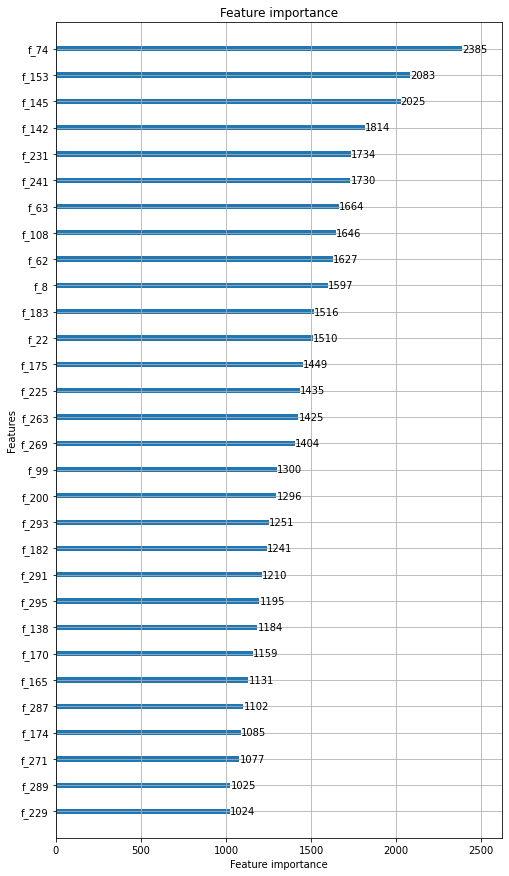

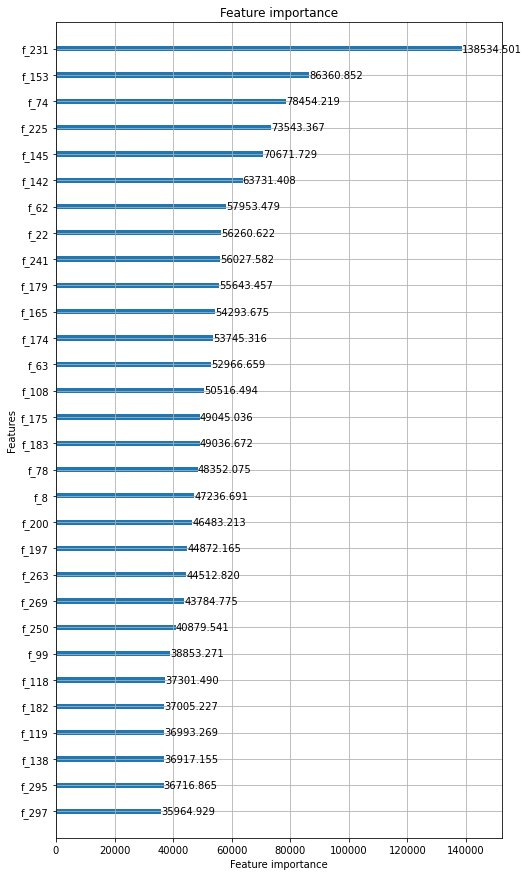

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913549	training's pearsonr: 0.154989
[100]	training's rmse: 0.910104	training's pearsonr: 0.172099
[150]	training's rmse: 0.908419	training's pearsonr: 0.18701
[200]	training's rmse: 0.906216	training's pearsonr: 0.199953
[250]	training's rmse: 0.903923	training's pearsonr: 0.213381
[300]	training's rmse: 0.902405	training's pearsonr: 0.224062
[350]	training's rmse: 0.900799	training's pearsonr: 0.233446
[400]	training's rmse: 0.899573	training's pearsonr: 0.241088
[450]	training's rmse: 0.898185	training's pearsonr: 0.248625
[500]	training's rmse: 0.896118	training's pearsonr: 0.25782
[550]	training's rmse: 0.89441	training's pearsonr: 0.267143
[600]	training's rmse: 0.893516	training's pearsonr: 0.273524
[650]	training's rmse: 0.892294	training's pearsonr: 0.279781
[700]	trainin

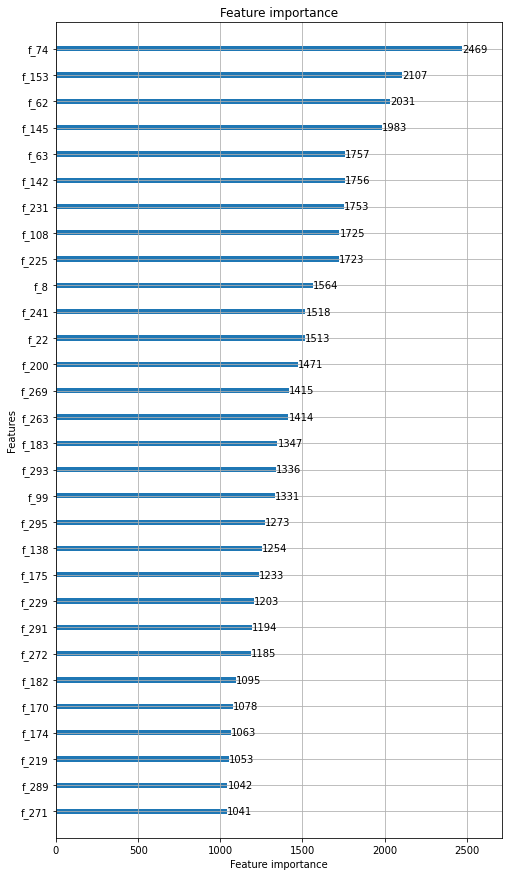

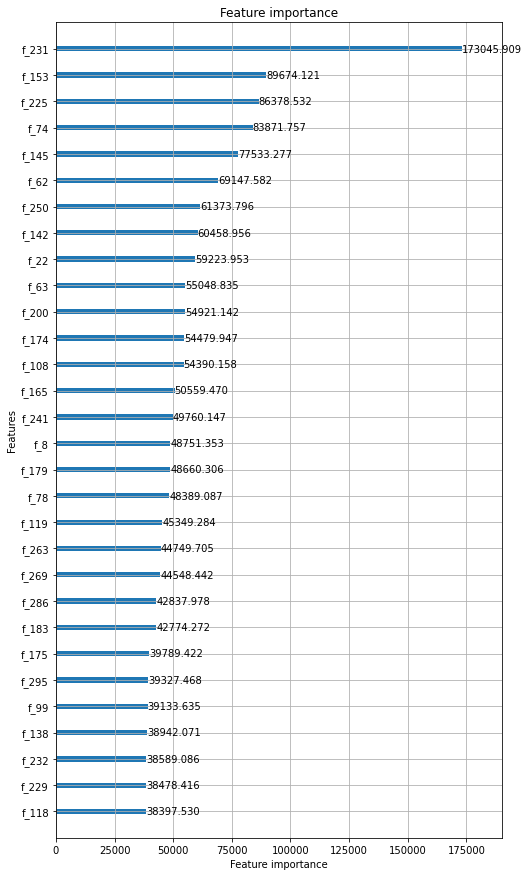

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913725	training's pearsonr: 0.154429
[100]	training's rmse: 0.910875	training's pearsonr: 0.169591
[150]	training's rmse: 0.90881	training's pearsonr: 0.184139
[200]	training's rmse: 0.907137	training's pearsonr: 0.195236
[250]	training's rmse: 0.904931	training's pearsonr: 0.207457
[300]	training's rmse: 0.903442	training's pearsonr: 0.217565
[350]	training's rmse: 0.901752	training's pearsonr: 0.228534
[400]	training's rmse: 0.89936	training's pearsonr: 0.239657
[450]	training's rmse: 0.898459	training's pearsonr: 0.247721
[500]	training's rmse: 0.897087	training's pearsonr: 0.254764
[550]	training's rmse: 0.895507	training's pearsonr: 0.262209
[600]	training's rmse: 0.894347	training's pearsonr: 0.269525
[650]	training's rmse: 0.892947	training's pearsonr: 0.276573
[700]	traini

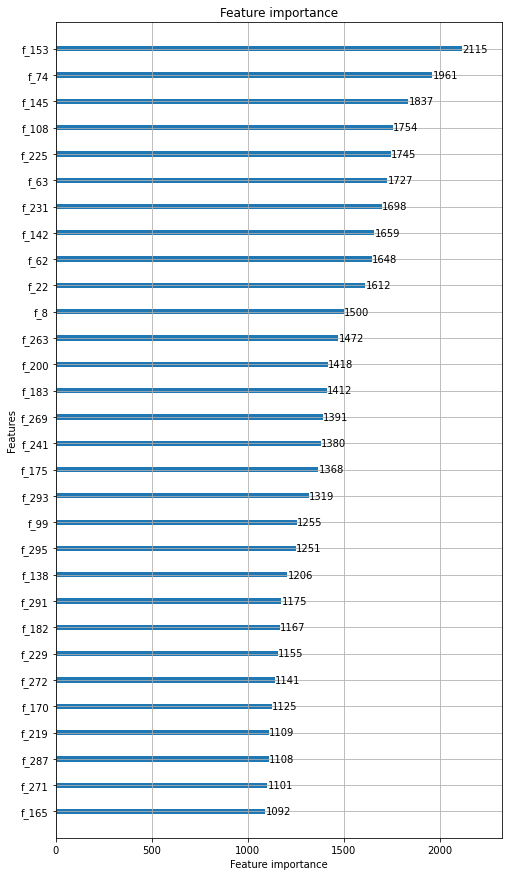

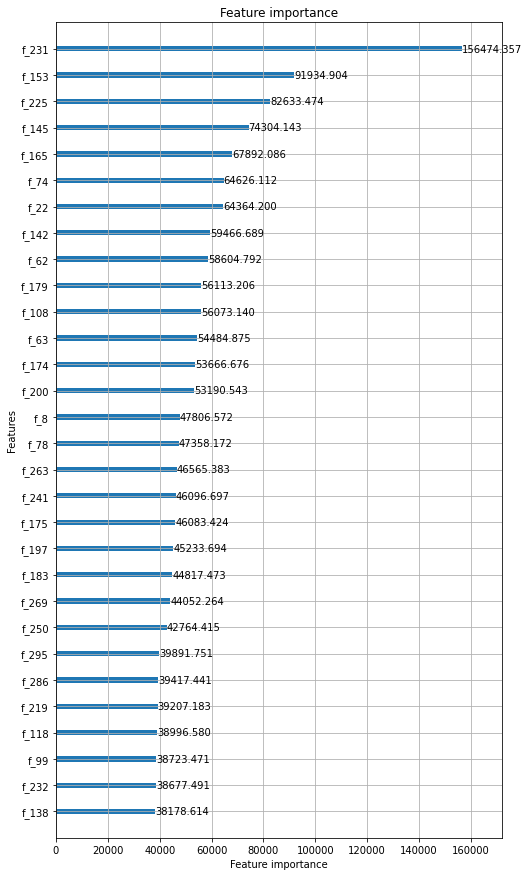

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.91291	training's pearsonr: 0.159533
[100]	training's rmse: 0.910861	training's pearsonr: 0.170337
[150]	training's rmse: 0.908081	training's pearsonr: 0.186901
[200]	training's rmse: 0.906344	training's pearsonr: 0.199201
[250]	training's rmse: 0.904935	training's pearsonr: 0.208709
[300]	training's rmse: 0.903083	training's pearsonr: 0.219598
[350]	training's rmse: 0.901796	training's pearsonr: 0.228165
[400]	training's rmse: 0.900298	training's pearsonr: 0.235883
[450]	training's rmse: 0.898543	training's pearsonr: 0.245736
[500]	training's rmse: 0.896799	training's pearsonr: 0.254339
[550]	training's rmse: 0.895444	training's pearsonr: 0.26265
[600]	training's rmse: 0.893866	training's pearsonr: 0.270589
[650]	training's rmse: 0.892434	training's pearsonr: 0.278408
[700]	traini

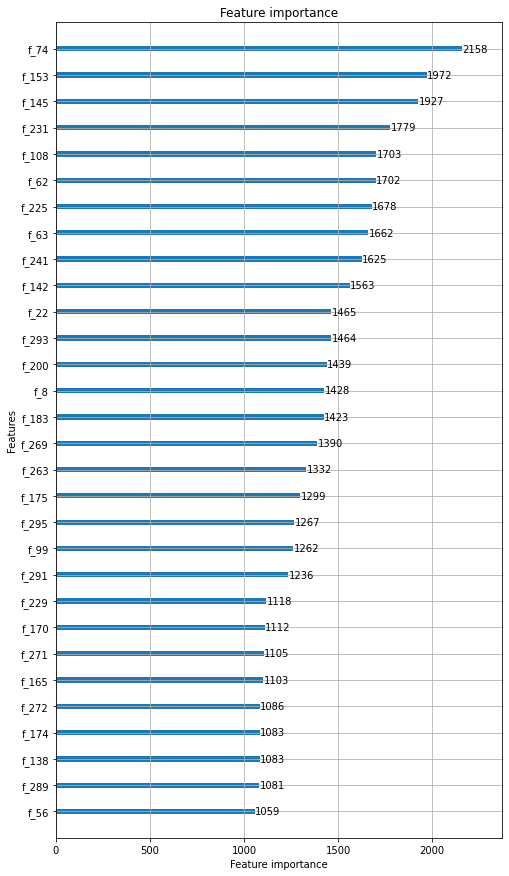

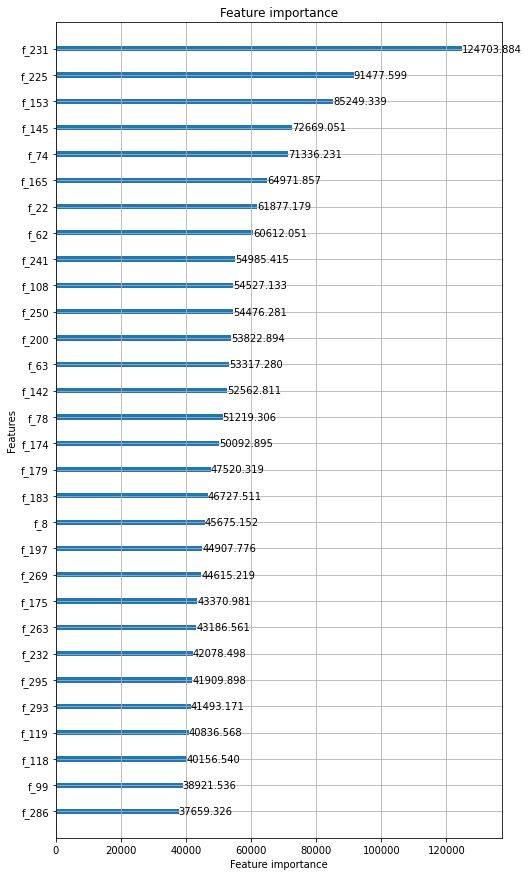

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.91386	training's pearsonr: 0.151571
[100]	training's rmse: 0.911563	training's pearsonr: 0.165323
[150]	training's rmse: 0.909963	training's pearsonr: 0.176307
[200]	training's rmse: 0.907756	training's pearsonr: 0.189609
[250]	training's rmse: 0.905367	training's pearsonr: 0.203706
[300]	training's rmse: 0.903653	training's pearsonr: 0.216117
[350]	training's rmse: 0.901916	training's pearsonr: 0.226386
[400]	training's rmse: 0.900201	training's pearsonr: 0.237004
[450]	training's rmse: 0.899001	training's pearsonr: 0.244604
[500]	training's rmse: 0.897672	training's pearsonr: 0.251898
[550]	training's rmse: 0.896277	training's pearsonr: 0.258982
[600]	training's rmse: 0.894521	training's pearsonr: 0.267507
[650]	training's rmse: 0.89282	training's pearsonr: 0.276222
[700]	traini

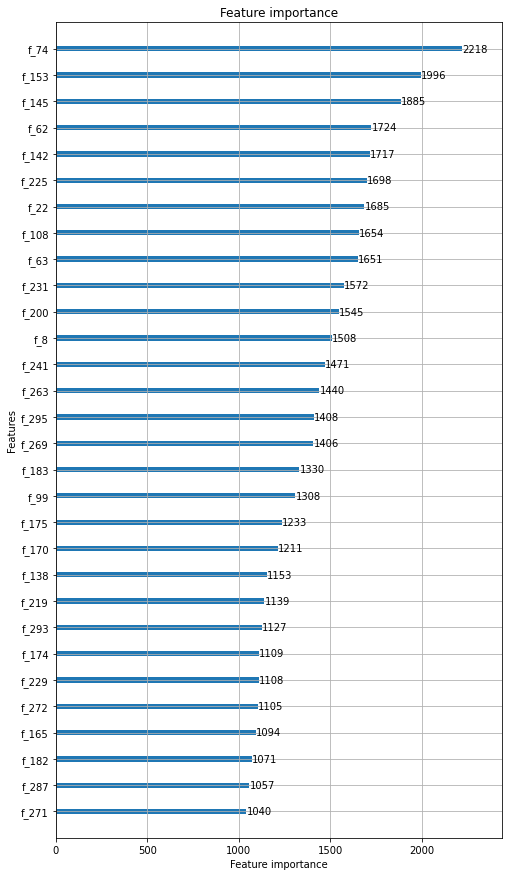

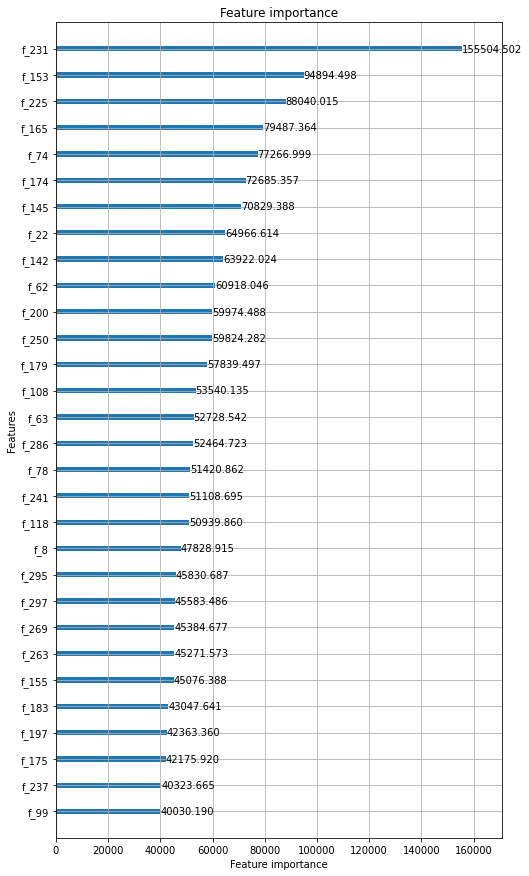

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913907	training's pearsonr: 0.1534
[100]	training's rmse: 0.909399	training's pearsonr: 0.176125
[150]	training's rmse: 0.906784	training's pearsonr: 0.194794
[200]	training's rmse: 0.905192	training's pearsonr: 0.207504
[250]	training's rmse: 0.903833	training's pearsonr: 0.21796
[300]	training's rmse: 0.901684	training's pearsonr: 0.227995
[350]	training's rmse: 0.90072	training's pearsonr: 0.23507
[400]	training's rmse: 0.899215	training's pearsonr: 0.243253
[450]	training's rmse: 0.897967	training's pearsonr: 0.250179
[500]	training's rmse: 0.895966	training's pearsonr: 0.259467
[550]	training's rmse: 0.894392	training's pearsonr: 0.268225
[600]	training's rmse: 0.893081	training's pearsonr: 0.27508
[650]	training's rmse: 0.892094	training's pearsonr: 0.281518
[700]	training's

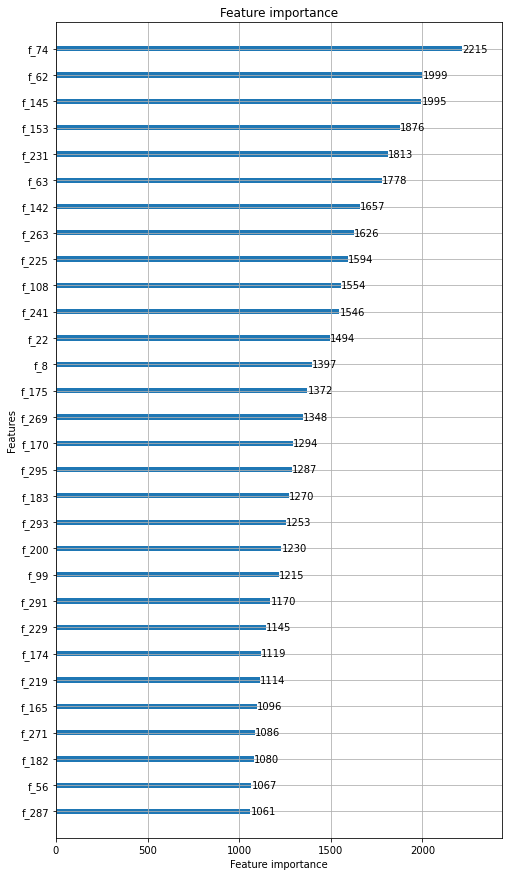

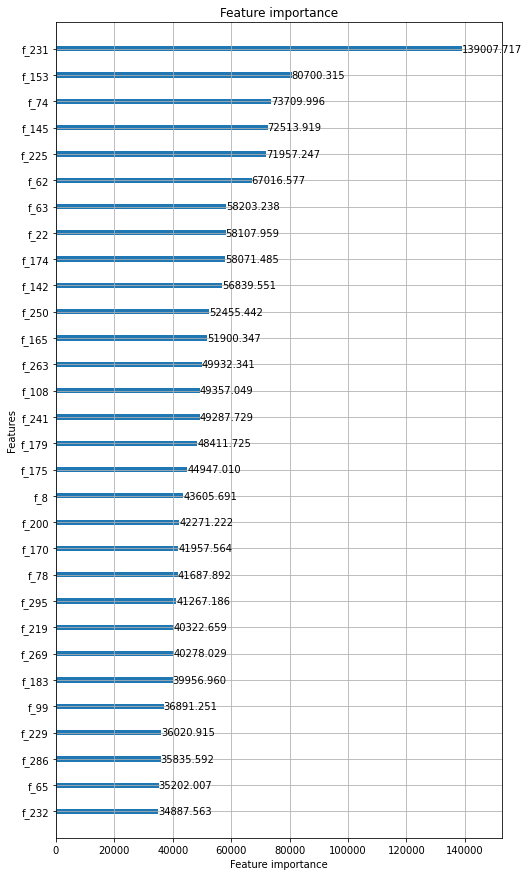

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913373	training's pearsonr: 0.156333
[100]	training's rmse: 0.910898	training's pearsonr: 0.171534
[150]	training's rmse: 0.909016	training's pearsonr: 0.181807
[200]	training's rmse: 0.906973	training's pearsonr: 0.194728
[250]	training's rmse: 0.904286	training's pearsonr: 0.210066
[300]	training's rmse: 0.903409	training's pearsonr: 0.219206
[350]	training's rmse: 0.902064	training's pearsonr: 0.226989
[400]	training's rmse: 0.900619	training's pearsonr: 0.235357
[450]	training's rmse: 0.899071	training's pearsonr: 0.244102
[500]	training's rmse: 0.897756	training's pearsonr: 0.251384
[550]	training's rmse: 0.896777	training's pearsonr: 0.257914
[600]	training's rmse: 0.895179	training's pearsonr: 0.265083
[650]	training's rmse: 0.8937	training's pearsonr: 0.272194
[700]	traini

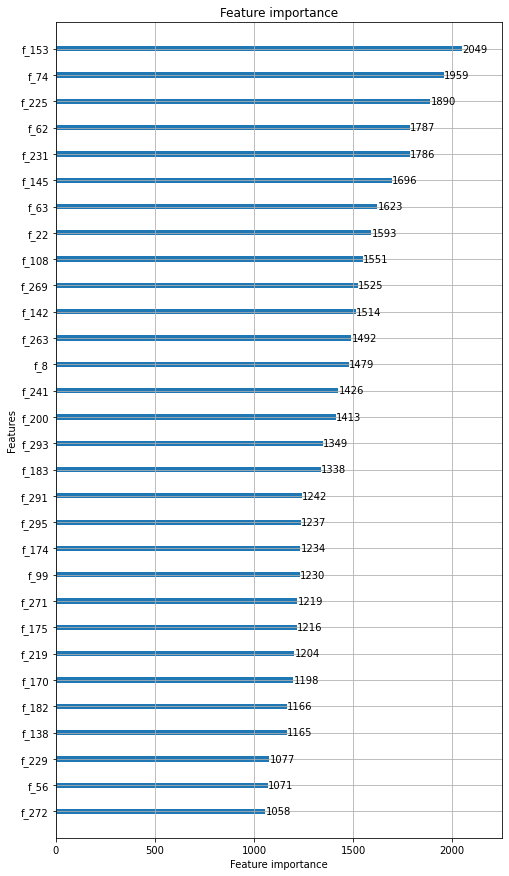

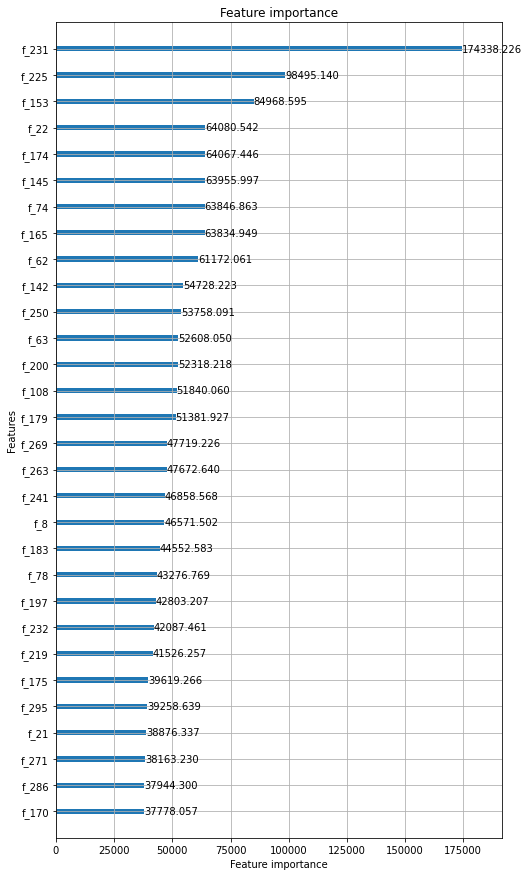

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913788	training's pearsonr: 0.153849
[100]	training's rmse: 0.911456	training's pearsonr: 0.16644
[150]	training's rmse: 0.909936	training's pearsonr: 0.178741
[200]	training's rmse: 0.906536	training's pearsonr: 0.195541
[250]	training's rmse: 0.905385	training's pearsonr: 0.206334
[300]	training's rmse: 0.903443	training's pearsonr: 0.217428
[350]	training's rmse: 0.901451	training's pearsonr: 0.228426
[400]	training's rmse: 0.899772	training's pearsonr: 0.238698
[450]	training's rmse: 0.898005	training's pearsonr: 0.248473
[500]	training's rmse: 0.896519	training's pearsonr: 0.256697
[550]	training's rmse: 0.895134	training's pearsonr: 0.264953
[600]	training's rmse: 0.893938	training's pearsonr: 0.271231
[650]	training's rmse: 0.892291	training's pearsonr: 0.279095
[700]	train

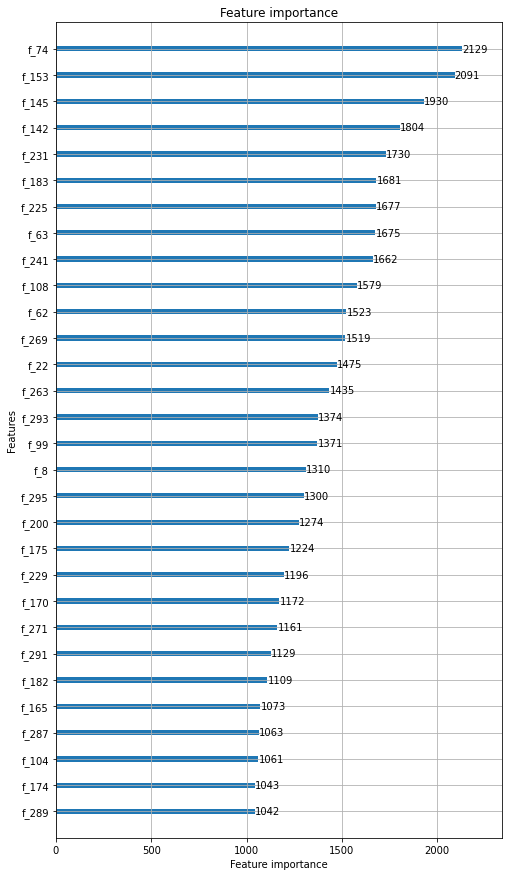

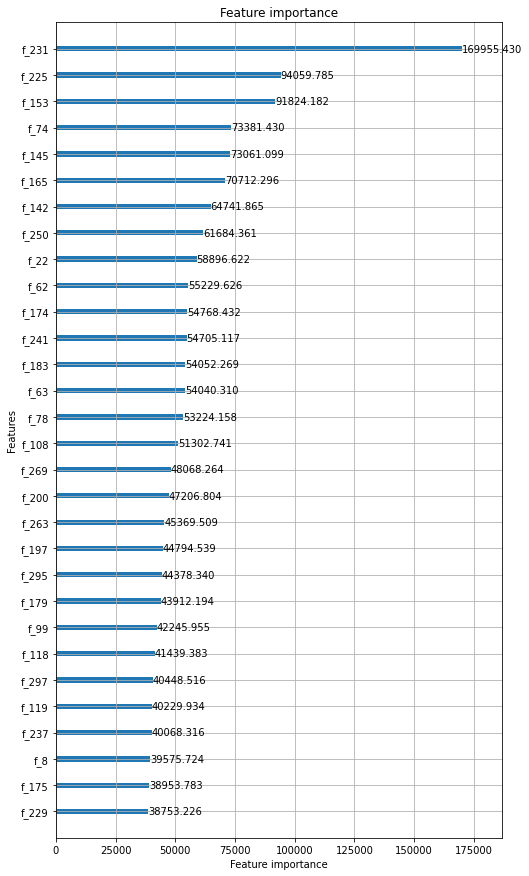

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913777	training's pearsonr: 0.154161
[100]	training's rmse: 0.911727	training's pearsonr: 0.166803
[150]	training's rmse: 0.909251	training's pearsonr: 0.180809
[200]	training's rmse: 0.906539	training's pearsonr: 0.195552
[250]	training's rmse: 0.904817	training's pearsonr: 0.20825
[300]	training's rmse: 0.903203	training's pearsonr: 0.21975
[350]	training's rmse: 0.90109	training's pearsonr: 0.230091
[400]	training's rmse: 0.899734	training's pearsonr: 0.239474
[450]	training's rmse: 0.898592	training's pearsonr: 0.247227
[500]	training's rmse: 0.897357	training's pearsonr: 0.254583
[550]	training's rmse: 0.896176	training's pearsonr: 0.260272
[600]	training's rmse: 0.894595	training's pearsonr: 0.267551
[650]	training's rmse: 0.893093	training's pearsonr: 0.275291
[700]	trainin

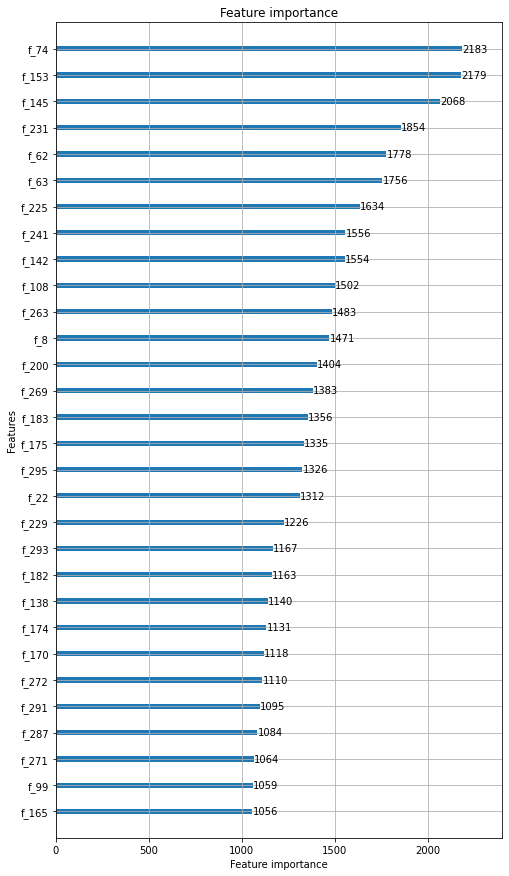

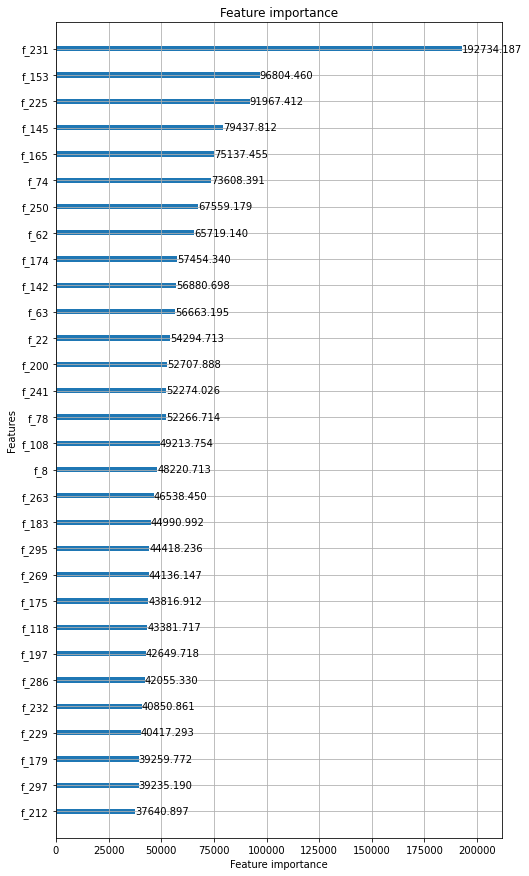

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914894	training's pearsonr: 0.15204
[100]	training's rmse: 0.910771	training's pearsonr: 0.171881
[150]	training's rmse: 0.909148	training's pearsonr: 0.181611
[200]	training's rmse: 0.906785	training's pearsonr: 0.195048
[250]	training's rmse: 0.905429	training's pearsonr: 0.205837
[300]	training's rmse: 0.903405	training's pearsonr: 0.216478
[350]	training's rmse: 0.902751	training's pearsonr: 0.223786
[400]	training's rmse: 0.901204	training's pearsonr: 0.231718
[450]	training's rmse: 0.90029	training's pearsonr: 0.238386
[500]	training's rmse: 0.898658	training's pearsonr: 0.245759
[550]	training's rmse: 0.896957	training's pearsonr: 0.254627
[600]	training's rmse: 0.895476	training's pearsonr: 0.262445
[650]	training's rmse: 0.89382	training's pearsonr: 0.270152
[700]	trainin

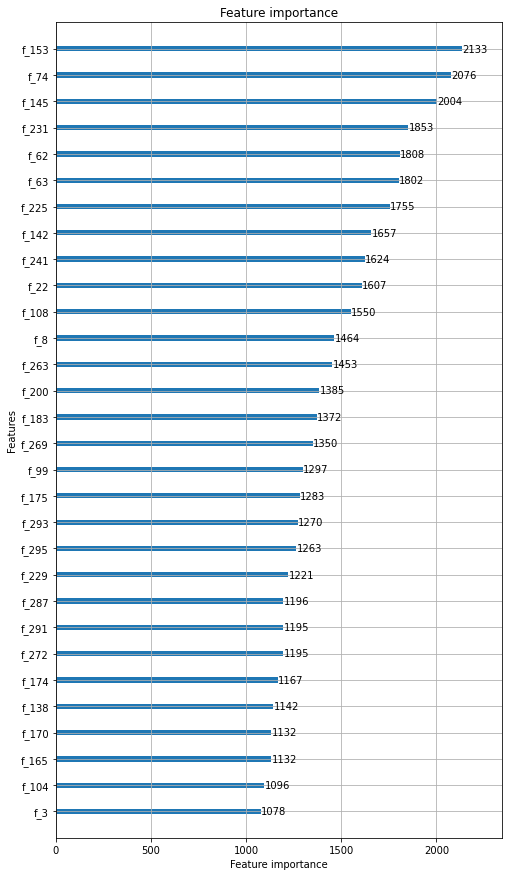

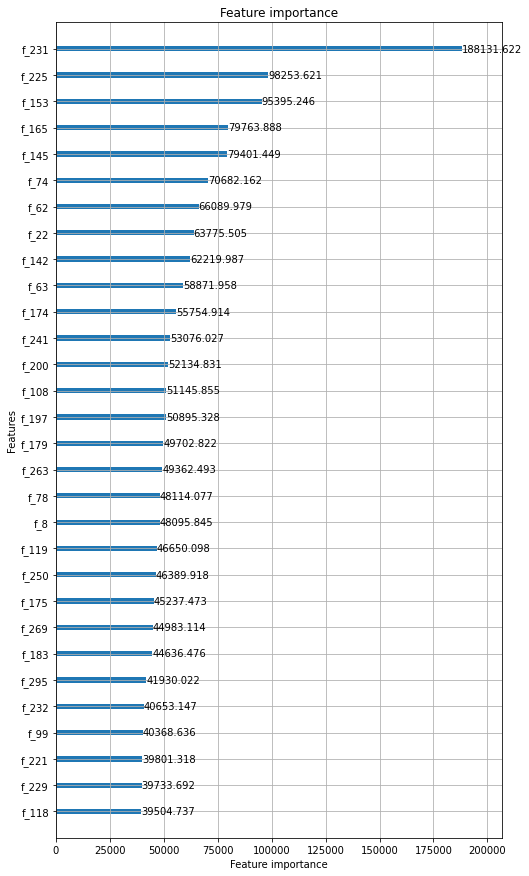

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914161	training's pearsonr: 0.152762
[100]	training's rmse: 0.91093	training's pearsonr: 0.171199
[150]	training's rmse: 0.908081	training's pearsonr: 0.187922
[200]	training's rmse: 0.90635	training's pearsonr: 0.201129
[250]	training's rmse: 0.904276	training's pearsonr: 0.212206
[300]	training's rmse: 0.902631	training's pearsonr: 0.223215
[350]	training's rmse: 0.901324	training's pearsonr: 0.231657
[400]	training's rmse: 0.899394	training's pearsonr: 0.241226
[450]	training's rmse: 0.897931	training's pearsonr: 0.249576
[500]	training's rmse: 0.896595	training's pearsonr: 0.257275
[550]	training's rmse: 0.895578	training's pearsonr: 0.263633
[600]	training's rmse: 0.893952	training's pearsonr: 0.271939
[650]	training's rmse: 0.892922	training's pearsonr: 0.277798
[700]	traini

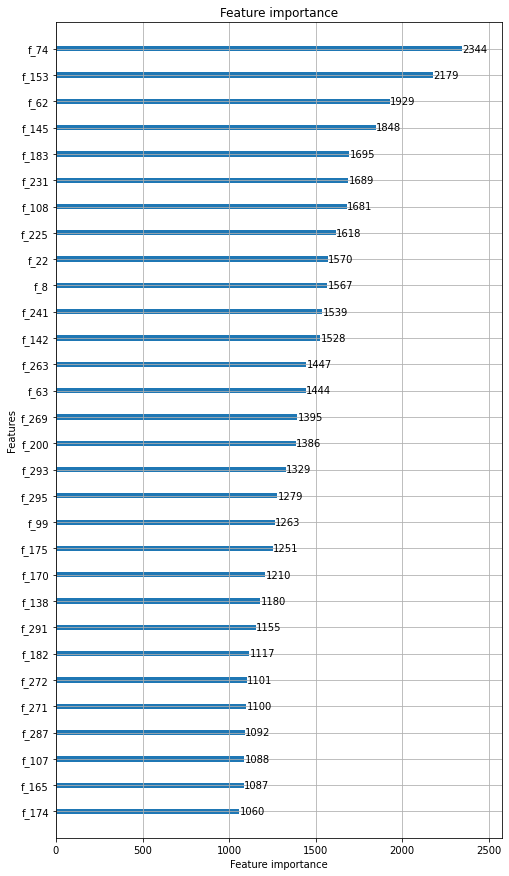

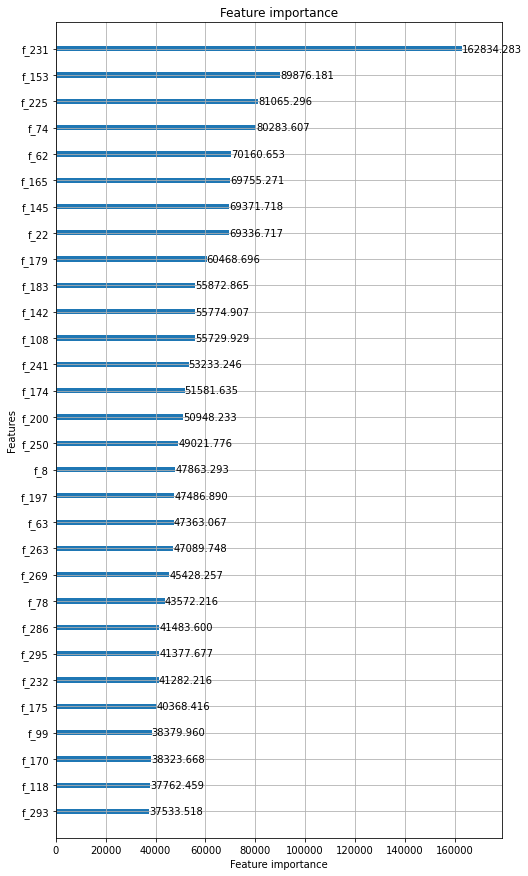

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913504	training's pearsonr: 0.155092
[100]	training's rmse: 0.911484	training's pearsonr: 0.169581
[150]	training's rmse: 0.908789	training's pearsonr: 0.183241
[200]	training's rmse: 0.906492	training's pearsonr: 0.197373
[250]	training's rmse: 0.904531	training's pearsonr: 0.209712
[300]	training's rmse: 0.903123	training's pearsonr: 0.219649
[350]	training's rmse: 0.901606	training's pearsonr: 0.229708
[400]	training's rmse: 0.90014	training's pearsonr: 0.237663
[450]	training's rmse: 0.89834	training's pearsonr: 0.247062
[500]	training's rmse: 0.897084	training's pearsonr: 0.254898
[550]	training's rmse: 0.895636	training's pearsonr: 0.262324
[600]	training's rmse: 0.894083	training's pearsonr: 0.270026
[650]	training's rmse: 0.892883	training's pearsonr: 0.276978
[700]	traini

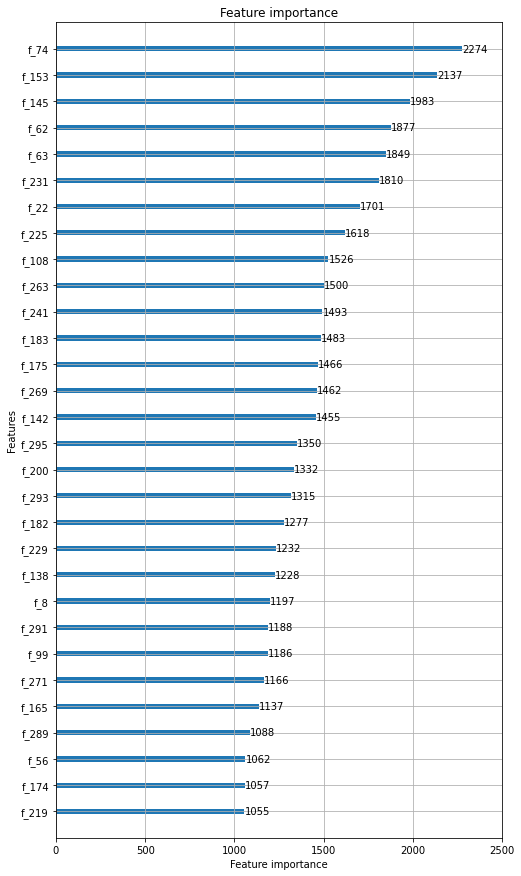

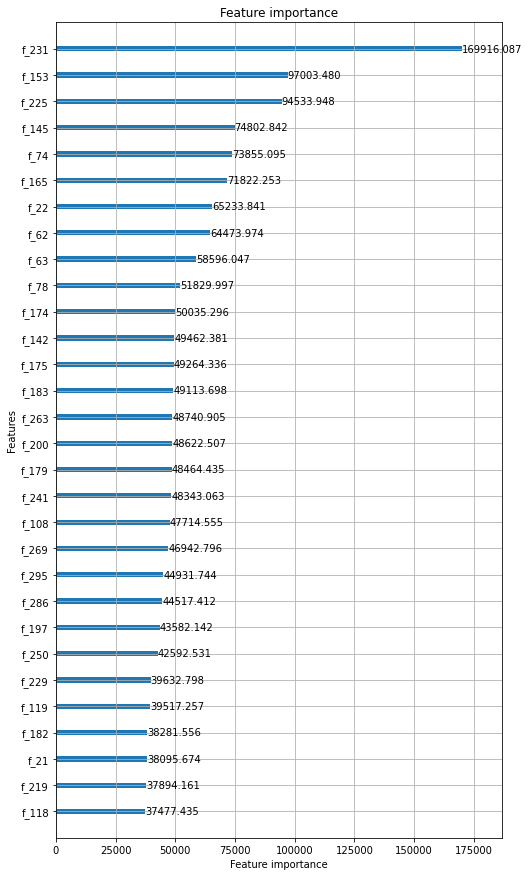

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913057	training's pearsonr: 0.15697
[100]	training's rmse: 0.911537	training's pearsonr: 0.168401
[150]	training's rmse: 0.90891	training's pearsonr: 0.181821
[200]	training's rmse: 0.906035	training's pearsonr: 0.199136
[250]	training's rmse: 0.904513	training's pearsonr: 0.21142
[300]	training's rmse: 0.902913	training's pearsonr: 0.221702
[350]	training's rmse: 0.90139	training's pearsonr: 0.2313
[400]	training's rmse: 0.900245	training's pearsonr: 0.238205
[450]	training's rmse: 0.898558	training's pearsonr: 0.24688
[500]	training's rmse: 0.897523	training's pearsonr: 0.253751
[550]	training's rmse: 0.896149	training's pearsonr: 0.259935
[600]	training's rmse: 0.894492	training's pearsonr: 0.267852
[650]	training's rmse: 0.892922	training's pearsonr: 0.275712
[700]	training's 

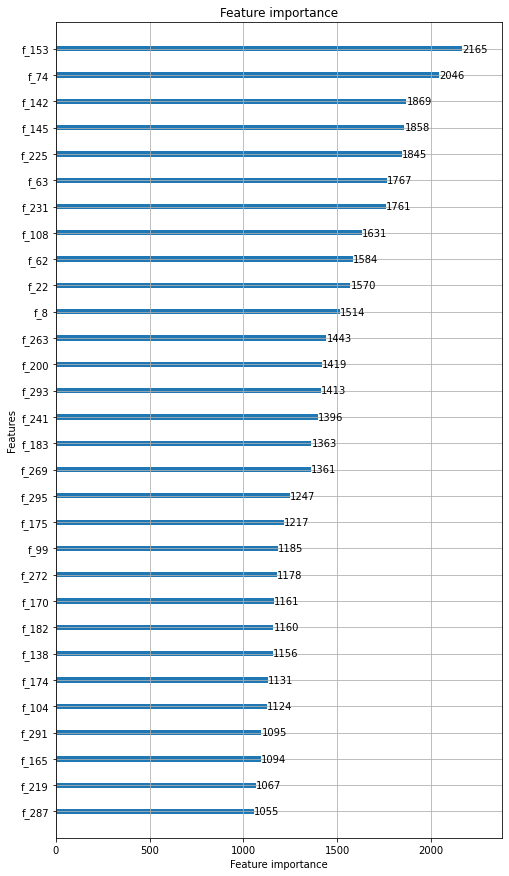

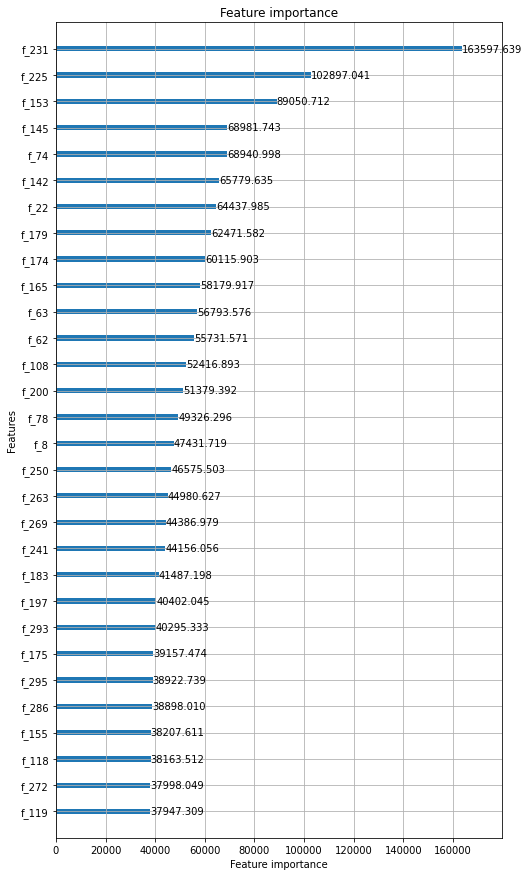

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913692	training's pearsonr: 0.154859
[100]	training's rmse: 0.911655	training's pearsonr: 0.167544
[150]	training's rmse: 0.910061	training's pearsonr: 0.177729
[200]	training's rmse: 0.907619	training's pearsonr: 0.190527
[250]	training's rmse: 0.90457	training's pearsonr: 0.207101
[300]	training's rmse: 0.902427	training's pearsonr: 0.221204
[350]	training's rmse: 0.900284	training's pearsonr: 0.234722
[400]	training's rmse: 0.899004	training's pearsonr: 0.24403
[450]	training's rmse: 0.897758	training's pearsonr: 0.252204
[500]	training's rmse: 0.89622	training's pearsonr: 0.259271
[550]	training's rmse: 0.894477	training's pearsonr: 0.267541
[600]	training's rmse: 0.893451	training's pearsonr: 0.274136
[650]	training's rmse: 0.892099	training's pearsonr: 0.280962
[700]	trainin

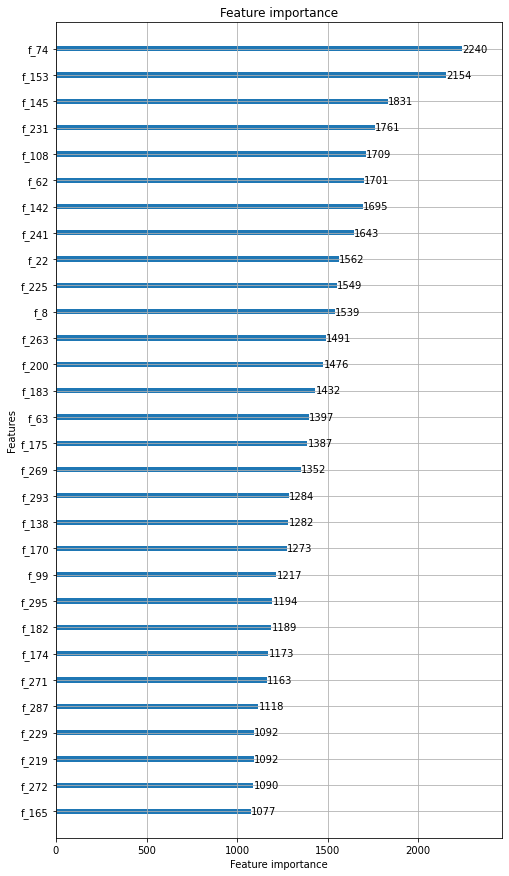

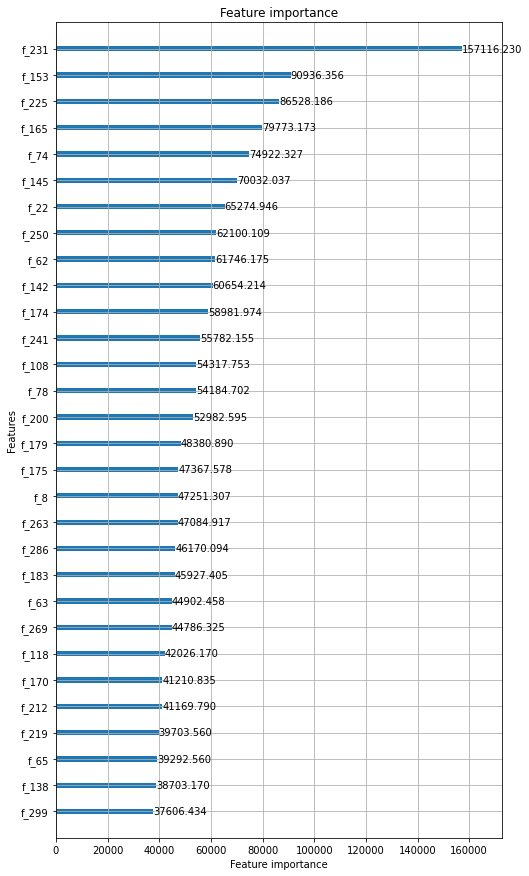

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.912491	training's pearsonr: 0.158706
[100]	training's rmse: 0.91021	training's pearsonr: 0.174952
[150]	training's rmse: 0.908038	training's pearsonr: 0.188006
[200]	training's rmse: 0.906811	training's pearsonr: 0.198104
[250]	training's rmse: 0.90566	training's pearsonr: 0.205737
[300]	training's rmse: 0.904009	training's pearsonr: 0.214842
[350]	training's rmse: 0.902131	training's pearsonr: 0.224465
[400]	training's rmse: 0.900561	training's pearsonr: 0.234
[450]	training's rmse: 0.899241	training's pearsonr: 0.242998
[500]	training's rmse: 0.897616	training's pearsonr: 0.250655
[550]	training's rmse: 0.895777	training's pearsonr: 0.259903
[600]	training's rmse: 0.894368	training's pearsonr: 0.268159
[650]	training's rmse: 0.893073	training's pearsonr: 0.274915
[700]	training'

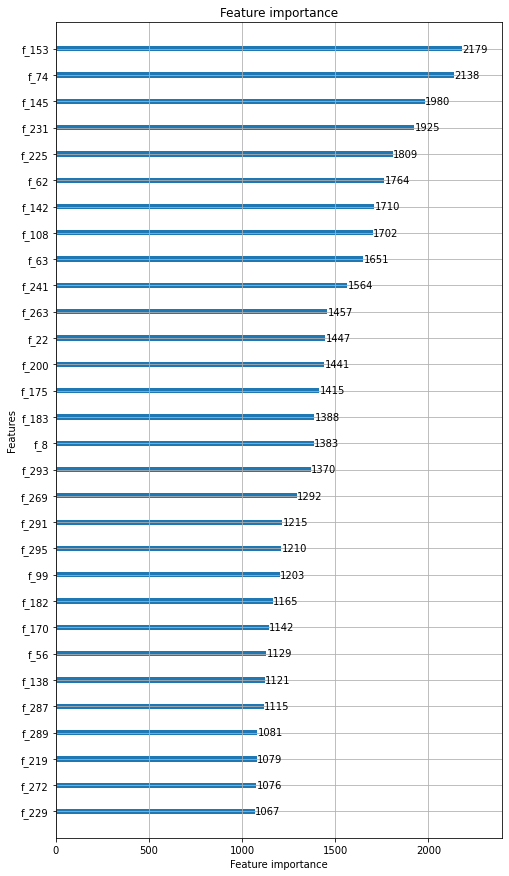

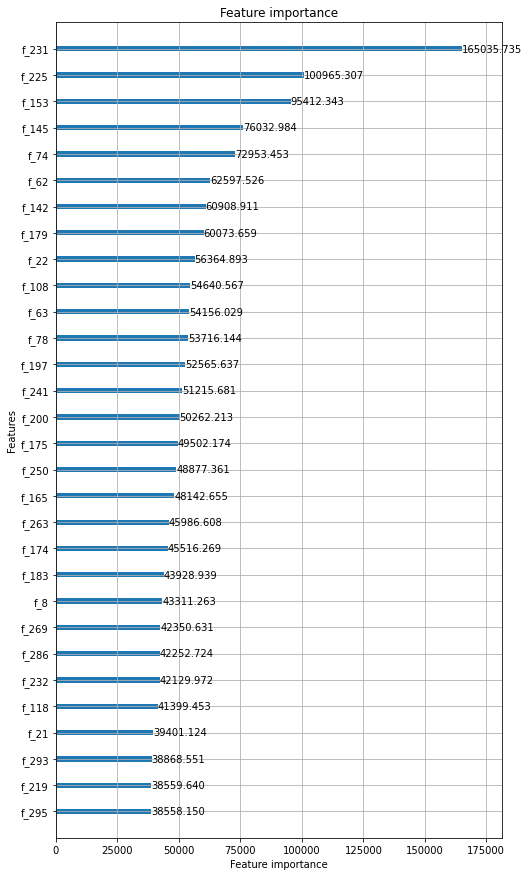

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.912999	training's pearsonr: 0.157176
[100]	training's rmse: 0.910378	training's pearsonr: 0.171555
[150]	training's rmse: 0.9088	training's pearsonr: 0.183042
[200]	training's rmse: 0.906543	training's pearsonr: 0.197567
[250]	training's rmse: 0.905407	training's pearsonr: 0.206296
[300]	training's rmse: 0.903128	training's pearsonr: 0.218271
[350]	training's rmse: 0.902015	training's pearsonr: 0.227424
[400]	training's rmse: 0.900428	training's pearsonr: 0.236442
[450]	training's rmse: 0.899189	training's pearsonr: 0.243602
[500]	training's rmse: 0.898178	training's pearsonr: 0.250214
[550]	training's rmse: 0.896554	training's pearsonr: 0.258076
[600]	training's rmse: 0.894854	training's pearsonr: 0.266173
[650]	training's rmse: 0.893362	training's pearsonr: 0.273969
[700]	traini

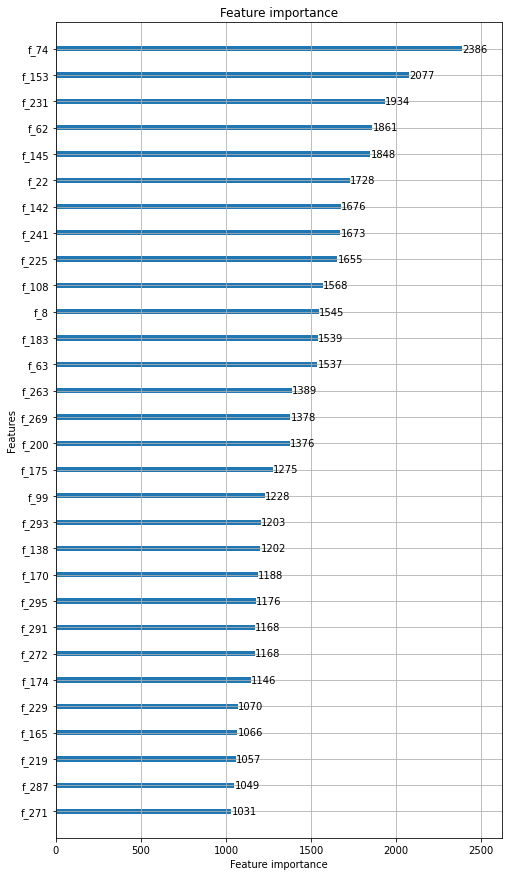

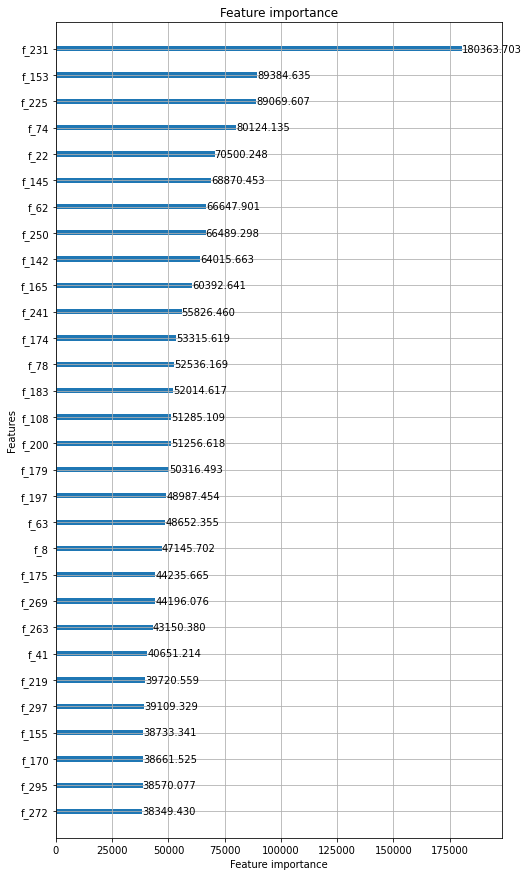

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.911636	training's pearsonr: 0.163416
[100]	training's rmse: 0.910102	training's pearsonr: 0.177761
[150]	training's rmse: 0.907999	training's pearsonr: 0.189837
[200]	training's rmse: 0.905881	training's pearsonr: 0.202664
[250]	training's rmse: 0.904281	training's pearsonr: 0.213908
[300]	training's rmse: 0.902325	training's pearsonr: 0.224466
[350]	training's rmse: 0.900583	training's pearsonr: 0.235435
[400]	training's rmse: 0.8985	training's pearsonr: 0.245873
[450]	training's rmse: 0.897089	training's pearsonr: 0.254099
[500]	training's rmse: 0.896126	training's pearsonr: 0.260771
[550]	training's rmse: 0.894626	training's pearsonr: 0.268122
[600]	training's rmse: 0.893558	training's pearsonr: 0.273963
[650]	training's rmse: 0.892546	training's pearsonr: 0.280048
[700]	traini

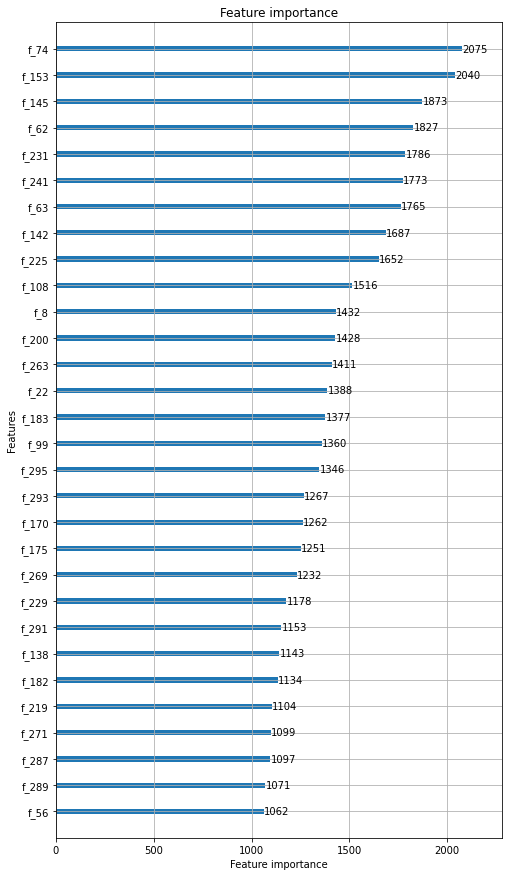

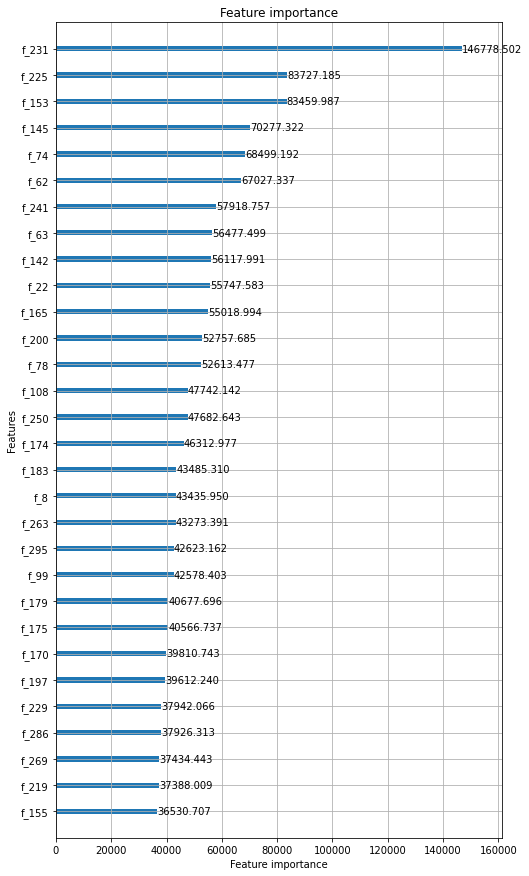

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914796	training's pearsonr: 0.151673
[100]	training's rmse: 0.910893	training's pearsonr: 0.168536
[150]	training's rmse: 0.908881	training's pearsonr: 0.1823
[200]	training's rmse: 0.906772	training's pearsonr: 0.196856
[250]	training's rmse: 0.905128	training's pearsonr: 0.207615
[300]	training's rmse: 0.903364	training's pearsonr: 0.217834
[350]	training's rmse: 0.902036	training's pearsonr: 0.226639
[400]	training's rmse: 0.900319	training's pearsonr: 0.236448
[450]	training's rmse: 0.898879	training's pearsonr: 0.24456
[500]	training's rmse: 0.897076	training's pearsonr: 0.254131
[550]	training's rmse: 0.895464	training's pearsonr: 0.262726
[600]	training's rmse: 0.893857	training's pearsonr: 0.27101
[650]	training's rmse: 0.892386	training's pearsonr: 0.278446
[700]	training

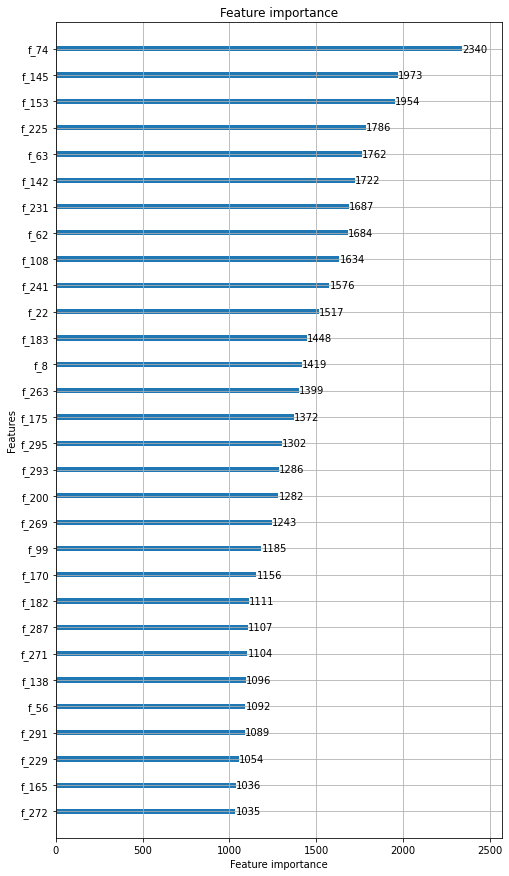

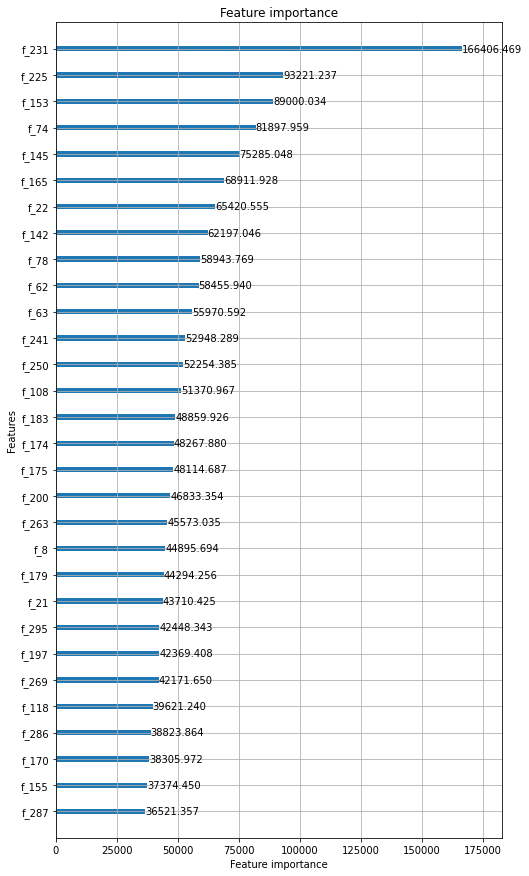

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913304	training's pearsonr: 0.156493
[100]	training's rmse: 0.910879	training's pearsonr: 0.170345
[150]	training's rmse: 0.908554	training's pearsonr: 0.183288
[200]	training's rmse: 0.906096	training's pearsonr: 0.198942
[250]	training's rmse: 0.90432	training's pearsonr: 0.211328
[300]	training's rmse: 0.902862	training's pearsonr: 0.220885
[350]	training's rmse: 0.900937	training's pearsonr: 0.23198
[400]	training's rmse: 0.899765	training's pearsonr: 0.239688
[450]	training's rmse: 0.897894	training's pearsonr: 0.24949
[500]	training's rmse: 0.896741	training's pearsonr: 0.257592
[550]	training's rmse: 0.8953	training's pearsonr: 0.264885
[600]	training's rmse: 0.893423	training's pearsonr: 0.273199
[650]	training's rmse: 0.891687	training's pearsonr: 0.281404
[700]	training'

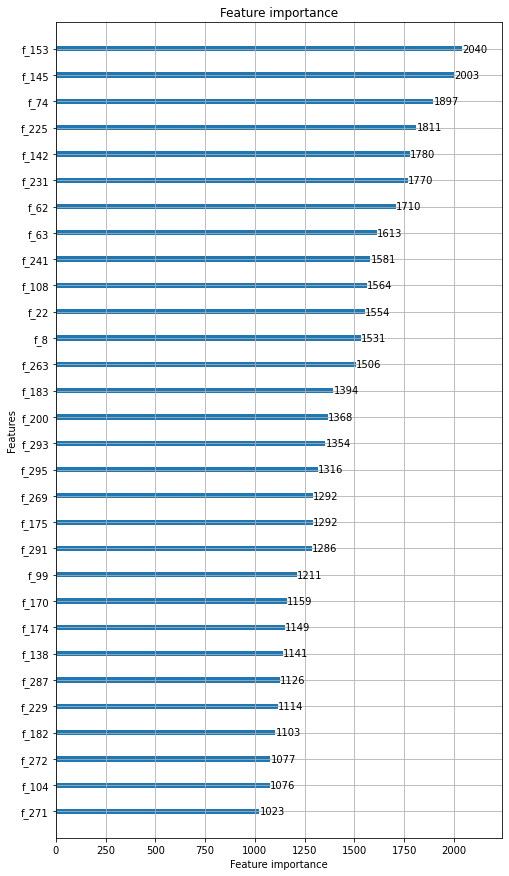

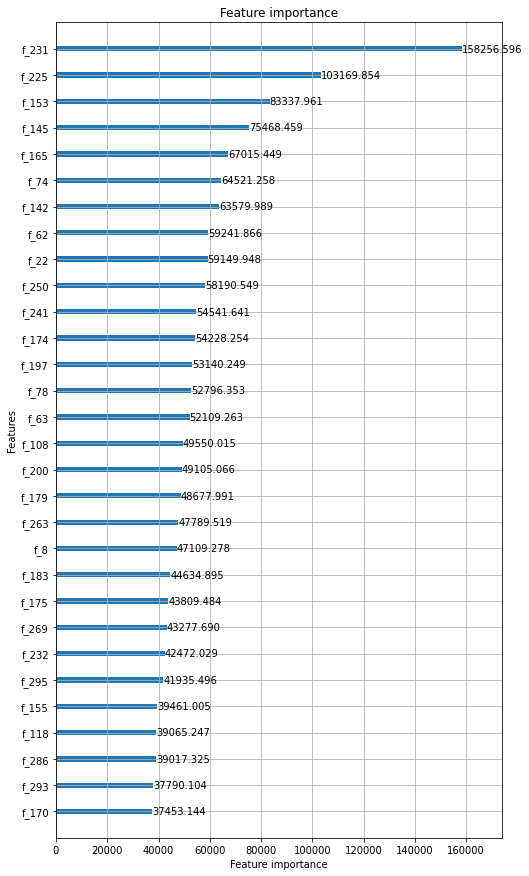

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914212	training's pearsonr: 0.151921
[100]	training's rmse: 0.911155	training's pearsonr: 0.168119
[150]	training's rmse: 0.908654	training's pearsonr: 0.183585
[200]	training's rmse: 0.90725	training's pearsonr: 0.194485
[250]	training's rmse: 0.905258	training's pearsonr: 0.205843
[300]	training's rmse: 0.903309	training's pearsonr: 0.218109
[350]	training's rmse: 0.901544	training's pearsonr: 0.228694
[400]	training's rmse: 0.900182	training's pearsonr: 0.237847
[450]	training's rmse: 0.89806	training's pearsonr: 0.248209
[500]	training's rmse: 0.897051	training's pearsonr: 0.256036
[550]	training's rmse: 0.895804	training's pearsonr: 0.262704
[600]	training's rmse: 0.894579	training's pearsonr: 0.269059
[650]	training's rmse: 0.893227	training's pearsonr: 0.27511
[700]	trainin

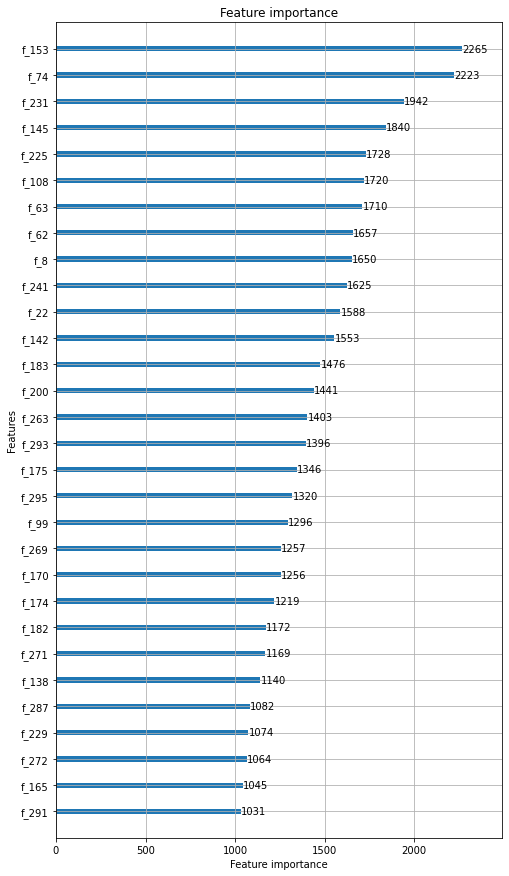

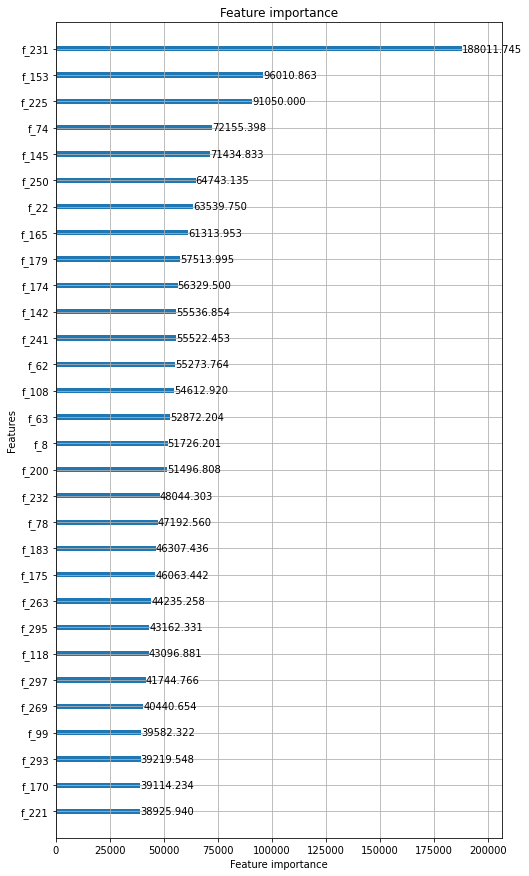

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914831	training's pearsonr: 0.148454
[100]	training's rmse: 0.912661	training's pearsonr: 0.160249
[150]	training's rmse: 0.910233	training's pearsonr: 0.174552
[200]	training's rmse: 0.908093	training's pearsonr: 0.18853
[250]	training's rmse: 0.906218	training's pearsonr: 0.198891
[300]	training's rmse: 0.904314	training's pearsonr: 0.210791
[350]	training's rmse: 0.90243	training's pearsonr: 0.222329
[400]	training's rmse: 0.900947	training's pearsonr: 0.232025
[450]	training's rmse: 0.899454	training's pearsonr: 0.241766
[500]	training's rmse: 0.897438	training's pearsonr: 0.251243
[550]	training's rmse: 0.896086	training's pearsonr: 0.260042
[600]	training's rmse: 0.894663	training's pearsonr: 0.267864
[650]	training's rmse: 0.893209	training's pearsonr: 0.275033
[700]	traini

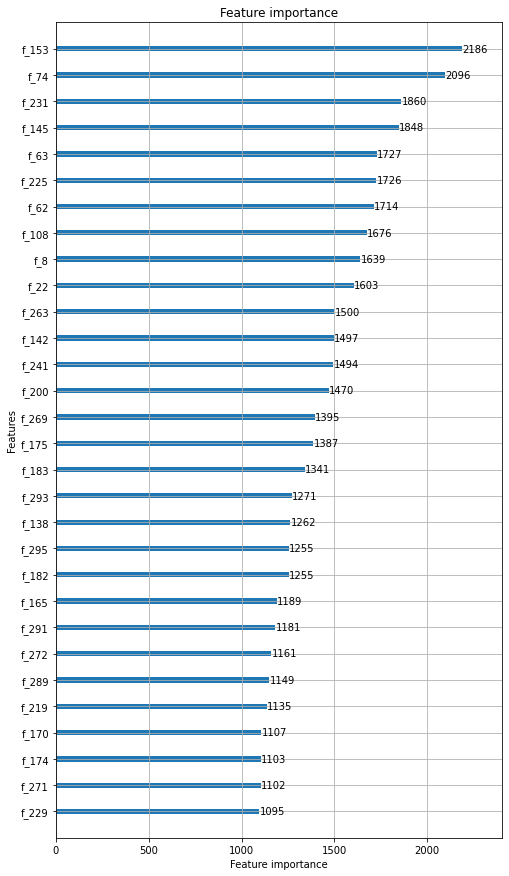

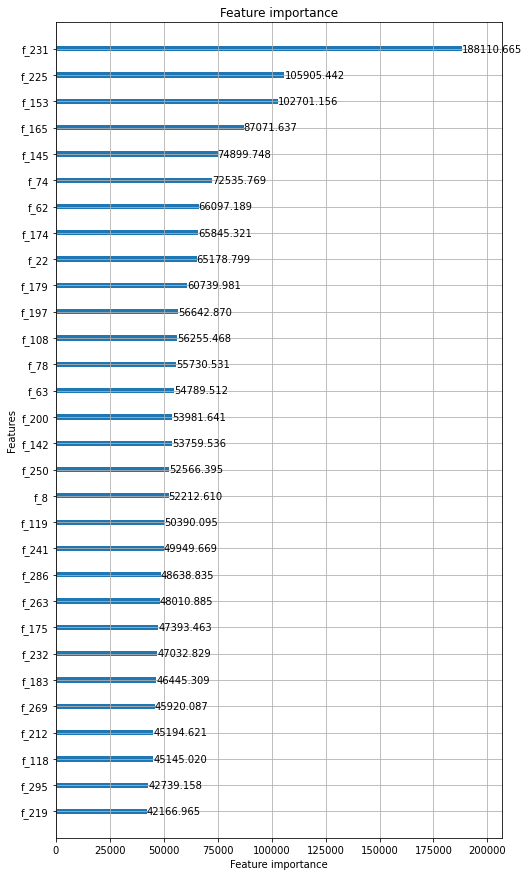

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.915981	training's pearsonr: 0.145974
[100]	training's rmse: 0.912941	training's pearsonr: 0.15772
[150]	training's rmse: 0.910632	training's pearsonr: 0.171785
[200]	training's rmse: 0.908453	training's pearsonr: 0.183933
[250]	training's rmse: 0.906386	training's pearsonr: 0.198071
[300]	training's rmse: 0.904254	training's pearsonr: 0.211288
[350]	training's rmse: 0.902299	training's pearsonr: 0.222719
[400]	training's rmse: 0.901136	training's pearsonr: 0.231729
[450]	training's rmse: 0.899519	training's pearsonr: 0.240363
[500]	training's rmse: 0.898113	training's pearsonr: 0.248948
[550]	training's rmse: 0.896176	training's pearsonr: 0.25799
[600]	training's rmse: 0.89515	training's pearsonr: 0.264897
[650]	training's rmse: 0.894015	training's pearsonr: 0.271293
[700]	trainin

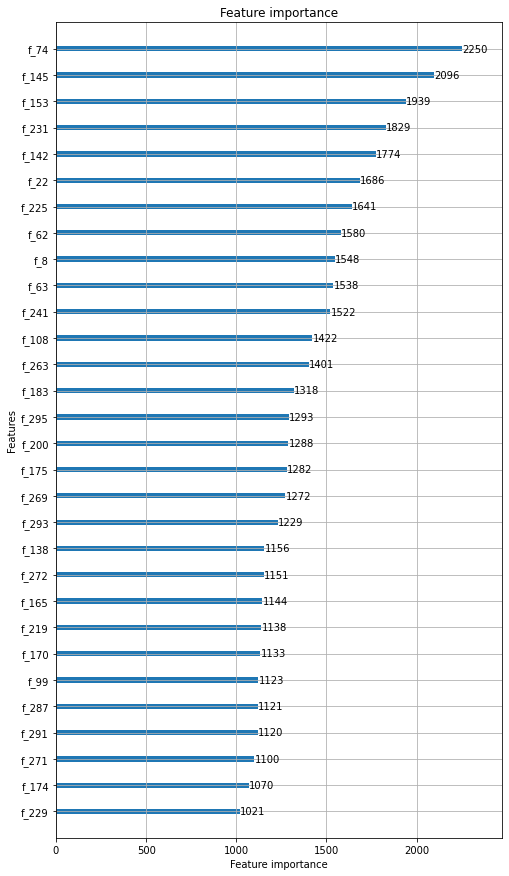

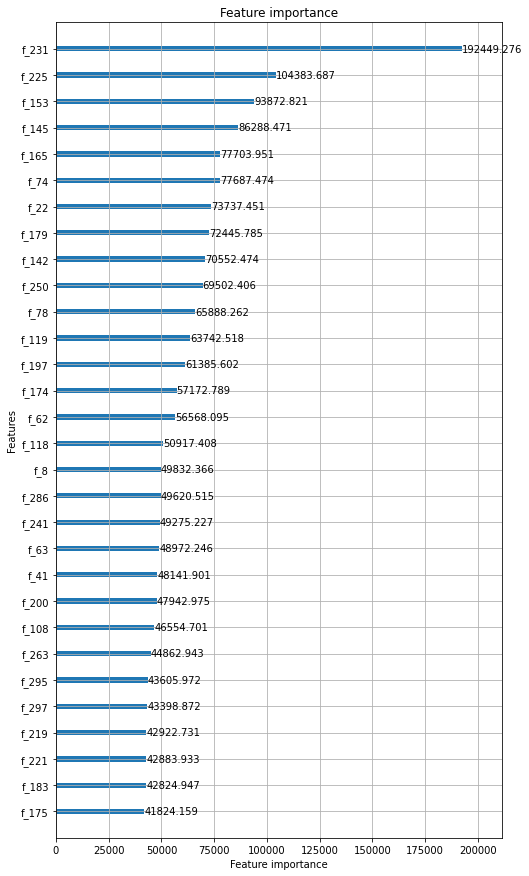

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.913701	training's pearsonr: 0.15334
[100]	training's rmse: 0.910192	training's pearsonr: 0.173329
[150]	training's rmse: 0.908671	training's pearsonr: 0.18523
[200]	training's rmse: 0.906973	training's pearsonr: 0.195195
[250]	training's rmse: 0.905374	training's pearsonr: 0.204998
[300]	training's rmse: 0.903297	training's pearsonr: 0.217292
[350]	training's rmse: 0.901616	training's pearsonr: 0.227789
[400]	training's rmse: 0.900368	training's pearsonr: 0.237216
[450]	training's rmse: 0.898254	training's pearsonr: 0.247856
[500]	training's rmse: 0.897066	training's pearsonr: 0.255643
[550]	training's rmse: 0.895562	training's pearsonr: 0.262964
[600]	training's rmse: 0.893764	training's pearsonr: 0.271525
[650]	training's rmse: 0.892191	training's pearsonr: 0.27943
[700]	trainin

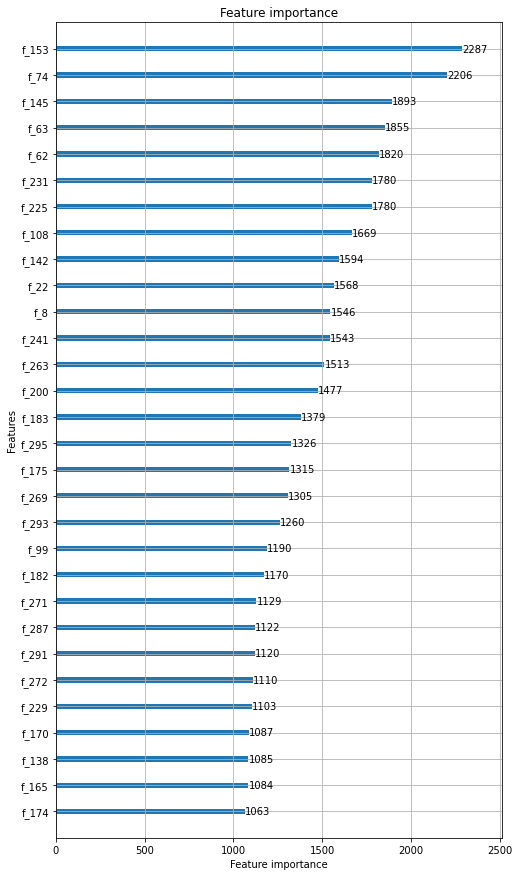

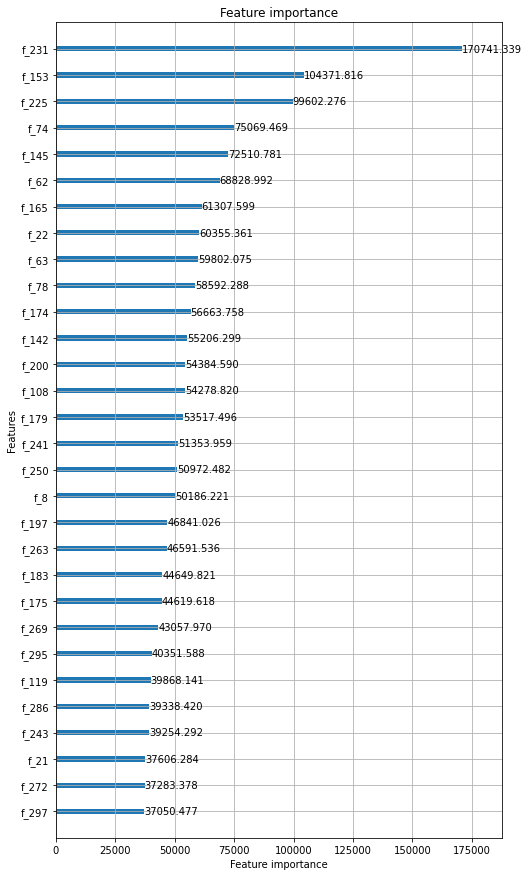

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.912062	training's pearsonr: 0.159988
[100]	training's rmse: 0.910773	training's pearsonr: 0.170788
[150]	training's rmse: 0.907958	training's pearsonr: 0.188112
[200]	training's rmse: 0.906626	training's pearsonr: 0.199891
[250]	training's rmse: 0.905023	training's pearsonr: 0.209756
[300]	training's rmse: 0.903374	training's pearsonr: 0.218942
[350]	training's rmse: 0.901847	training's pearsonr: 0.227656
[400]	training's rmse: 0.899789	training's pearsonr: 0.237412
[450]	training's rmse: 0.898581	training's pearsonr: 0.24495
[500]	training's rmse: 0.896852	training's pearsonr: 0.253538
[550]	training's rmse: 0.89582	training's pearsonr: 0.260975
[600]	training's rmse: 0.894115	training's pearsonr: 0.269633
[650]	training's rmse: 0.892998	training's pearsonr: 0.275544
[700]	traini

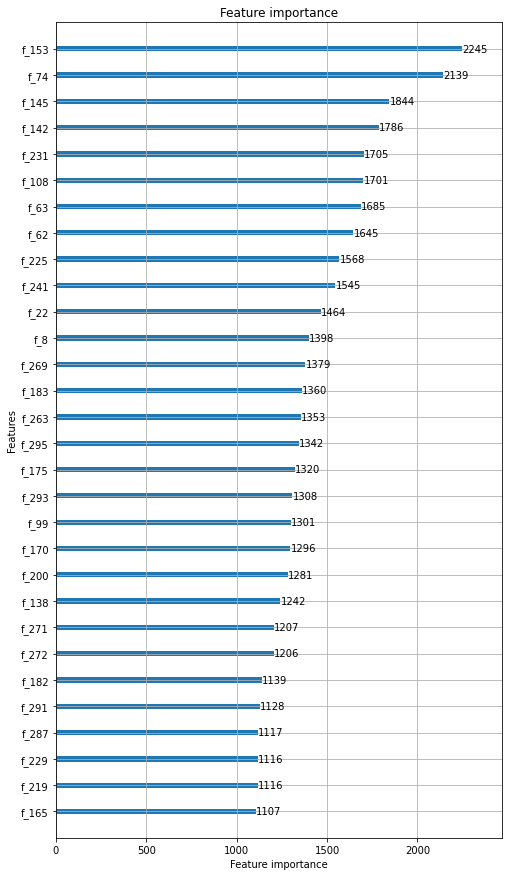

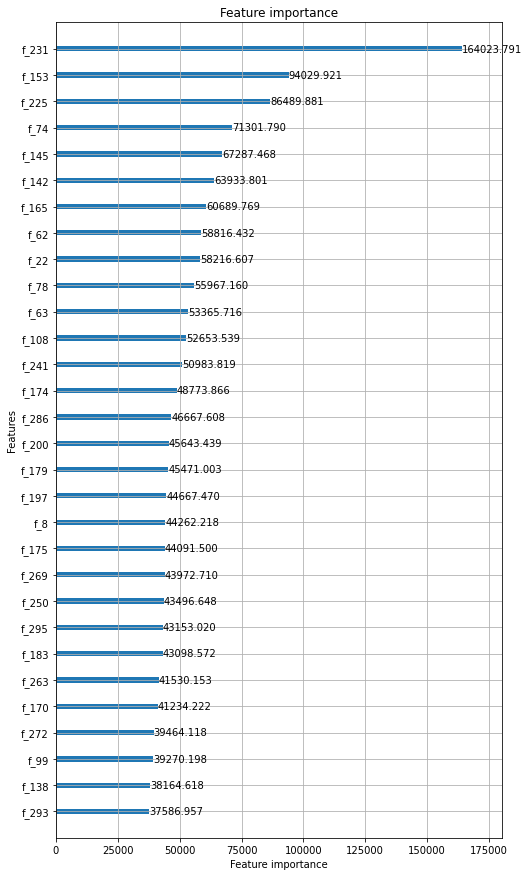

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[50]	training's rmse: 0.914213	training's pearsonr: 0.153349
[100]	training's rmse: 0.910813	training's pearsonr: 0.16981
[150]	training's rmse: 0.909119	training's pearsonr: 0.18209
[200]	training's rmse: 0.90713	training's pearsonr: 0.194444
[250]	training's rmse: 0.90572	training's pearsonr: 0.203906
[300]	training's rmse: 0.90335	training's pearsonr: 0.216615
[350]	training's rmse: 0.901972	training's pearsonr: 0.22622
[400]	training's rmse: 0.900212	training's pearsonr: 0.23606
[450]	training's rmse: 0.898091	training's pearsonr: 0.247029
[500]	training's rmse: 0.896682	training's pearsonr: 0.256202
[550]	training's rmse: 0.895239	training's pearsonr: 0.264131
[600]	training's rmse: 0.89381	training's pearsonr: 0.271727
[650]	training's rmse: 0.892336	training's pearsonr: 0.279303
[700]	training's r

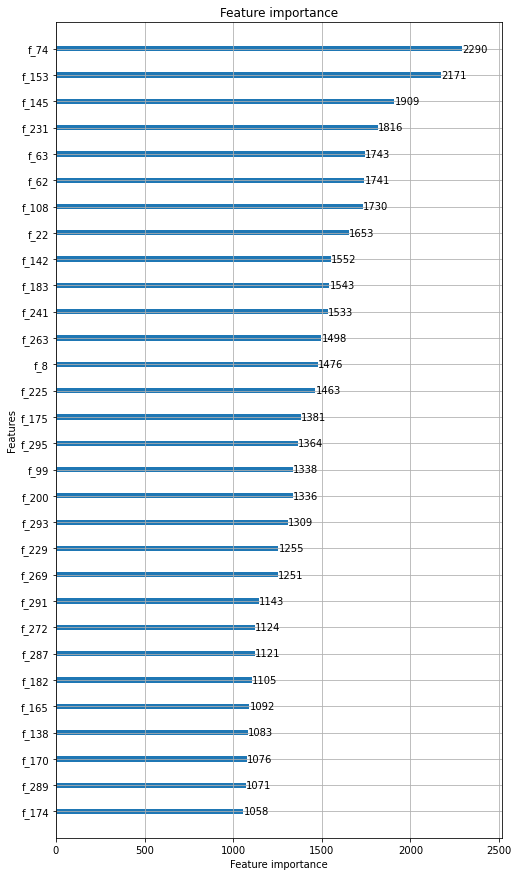

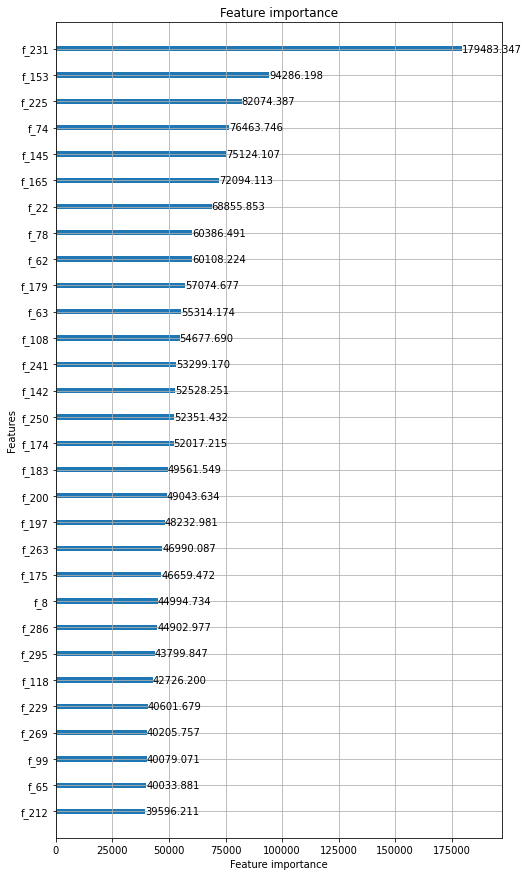

In [14]:
seeds = [
    2, 3, 5, 7, 11, 
    13, 17, 19, 23, 29, 
    31, 37, 41, 43, 47, 
    53, 59, 61, 67, 71, 
    73, 79, 83, 89, 97,
]
models = list()

for seed in seeds:
    model_params["seed"] = seed
    model_params["drop_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[lgb.log_evaluation(period=50)],
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-dart/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***